# Import Libraries

In [1]:
import numpy as np



import torch



import torch.nn as nn



torch._dynamo.config.suppress_errors = True



import torch.optim as optim



import torch.nn.functional as F



import random



from collections import namedtuple, deque



import gym



from tqdm import trange



import matplotlib.pyplot as plt



import json

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

print(device)

cuda


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [3]:
import warnings



warnings.filterwarnings('ignore')

# Network

In [4]:
# Define the neural network model

class QNetwork(nn.Module):

    def __init__(self, state_size, action_size, seed, depth, fc_unit, final_layer_unit, feature_path = None):

        super().__init__()

        self.seed = torch.manual_seed(seed)

        self.feature_size = 128

        self.feature_layer = nn.Linear(state_size, self.feature_size)

        if feature_path is None:
          self.init_weights(self.feature_layer)
        else:
          self.feature_layer.load_state_dict(torch.load(feature_path))
          self.feature_layer.requires_grad_(False)

        self.layers = nn.ModuleList()

        for i in range(depth):

            if depth == 1:

                self.layers.append(nn.Linear(self.feature_size, final_layer_unit))

            elif i == 0:

                self.layers.append(nn.Linear(self.feature_size, fc_unit))

            elif i == depth - 1:

                self.layers.append(nn.Linear(fc_unit, final_layer_unit))

            else:

                self.layers.append(nn.Linear(fc_unit, fc_unit))



        for layer in self.layers:

          self.init_weights(layer)



        if depth > 0:

          self.final_layer = nn.Linear(final_layer_unit, action_size)

        else:

          self.final_layer = nn.Linear(self.feature_size, action_size)



        #nn.init.zeros_(self.final_layer.weight)

        #nn.init.zeros_(self.final_layer.bias)

        self.init_weights(self.final_layer)



    def init_weights(self, layer):

        nn.init.xavier_normal(layer.weight)

        self.to(device)



    def forward(self, state):

        x = self.feature_layer(state)
        x = F.relu(x)
        for layer in self.layers:
            x = layer(x)
        return self.final_layer(x)


# ReplayBuffer

In [5]:
class ReplayBuffer:



    def __init__(self, action_size, buffer_size, batch_size, seed):



        self.action_size = action_size



        self.memory = deque(maxlen=buffer_size)



        self.batch_size = batch_size



        self.experience = namedtuple("Experience", field_names=["state", "action", "reward", "next_state", "done"])



        self.seed = random.seed(seed)







    def add(self, state, action, reward, next_state, done):



        e = self.experience(state, action, reward, next_state, done)



        self.memory.append(e)







    def sample(self):



        experiences = random.sample(self.memory, k=self.batch_size)







        states = torch.from_numpy(np.vstack([e.state for e in experiences if e is not None])).float().to(device)



        actions = torch.from_numpy(np.vstack([e.action for e in experiences if e is not None])).long().to(device)



        rewards = torch.from_numpy(np.vstack([e.reward for e in experiences if e is not None])).float().to(device)



        next_states = torch.from_numpy(np.vstack([e.next_state for e in experiences if e is not None])).float().to(device)



        dones = torch.from_numpy(np.vstack([e.done for e in experiences if e is not None]).astype(np.uint8)).float().to(device)







        return (states, actions, rewards, next_states, dones)







    def __len__(self):



        return len(self.memory)

# DQN

In [6]:
# Define the DQN agent class

class DQNAgent:

    # Initialize the DQN agent

    def __init__(self, state_size, action_size, seed, lr, network):

        self.state_size = state_size

        self.action_size = action_size

        self.seed = random.seed(seed)



        self.qnetwork_local = QNetwork(state_size, action_size, seed, network["depth"], network["fc_units"], network["final_fc_units"], network["feature_path"]).to(device)

        self.qnetwork_target = QNetwork(state_size, action_size, seed, network["depth"], network["fc_units"], network["final_fc_units"], network["feature_path"]).to(device)

        self.optimizer = optim.Adam(self.qnetwork_local.parameters(), lr)



        self.memory = ReplayBuffer(action_size, buffer_size=int(1e5), batch_size=64, seed=seed)

        self.t_step = 0



    def step(self, state, action, reward, next_state, done):

        self.memory.add(state, action, reward, next_state, done)



        self.t_step = (self.t_step + 1) % 4

        if self.t_step == 0:

            if len(self.memory) > 64:

                experiences = self.memory.sample()

                self.learn(experiences, gamma=0.99)



    # Choose an action based on the current state

    def act(self, state, eps=0.):

        #print(state)

        state_tensor = torch.from_numpy(state).float().unsqueeze(0).to(device)

        self.qnetwork_local.eval()

        with torch.no_grad():

            action_values = self.qnetwork_local(state_tensor)

        self.qnetwork_local.train()



        if np.random.random() > eps:

            return action_values.argmax(dim=1).item()

        else:

            return np.random.randint(self.action_size)



    # Learn from batch of experiences

    def learn(self, experiences, gamma):

        states, actions, rewards, next_states, dones = zip(*experiences)

        states = torch.from_numpy(np.vstack(states)).float().to(device)

        actions = torch.from_numpy(np.vstack(actions)).long().to(device)

        rewards = torch.from_numpy(np.vstack(rewards)).float().to(device)

        next_states = torch.from_numpy(np.vstack(next_states)).float().to(device)

        dones = torch.from_numpy(np.vstack(dones).astype(np.uint8)).float().to(device)



        Q_targets_next = self.qnetwork_target(next_states).detach().max(1)[0].unsqueeze(1)

        Q_targets = rewards + (gamma * Q_targets_next * (1 - dones))



        Q_expected = self.qnetwork_local(states).gather(1, actions)



        loss = F.mse_loss(Q_expected, Q_targets)

        self.optimizer.zero_grad()

        loss.backward()

        self.optimizer.step()



        self.soft_update(self.qnetwork_local, self.qnetwork_target, tau=1e-3)



        return loss



    def soft_update(self, local_model, target_model, tau):

        for target_param, local_param in zip(target_model.parameters(), local_model.parameters()):

            target_param.data.copy_(tau * local_param.data + (1.0 - tau) * target_param.data)

# Hyperparameters

In [7]:
num_episodes = 3000

max_steps_per_episode_train = 150

#max_steps_per_episode_eval = 25

epsilon_start = 1.0

epsilon_end = 0.01

epsilon_decay_rate = 0.99

gamma = 0.99

buffer_size = 10000

batch_size = 128

update_frequency = 10

test_episodes = 1

# Setup Environment

In [8]:
#env_id = "Gym-Gridworlds/DangerMaze-6x6-v0"



#env_id = "Gym-Gridworlds/Empty-10x10-v0"



#env_id = "Gym-Gridworlds/Penalty-3x3-v0"



#env = gymnasium.make(env_id, render_mode="binary")



#env_eval = gymnasium.make(env_id, max_episode_steps=max_steps_per_episode_eval, render_mode="binary")



env = gym.make('Acrobot-v1')



env_eval = gym.make('Acrobot-v1')

# DQN Agent

In [9]:
input_dim = env.observation_space.shape[0]

output_dim = env.action_space.n

#depths = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 20, 50]

#fc_units = [500, 366, 262, 215, 187, 168, 153, 142, 133, 125, 87, 54]

#final_units = [500, 366, 263, 217, 188, 165, 157, 144, 134, 135, 75, 54]

depths = [1, 3, 5, 7, 10, 50]

fc_units = [1024, 229, 168, 139, 115, 51]

final_units = [1024, 227, 165, 139, 114, 40]

feature_path = None

networks = [QNetwork(input_dim, output_dim, seed=i, depth=depths[i], fc_unit=fc_units[i], final_layer_unit=final_units[i], feature_path=feature_path) for i in range(len(depths))]

netwrok_names = [f"DQN_{depths[i]:02}_{fc_units[i]}_{sum(p.numel() for p in networks[i].parameters())}" for i in range(len(depths))]

data = {}

for network in networks:

  data[network] = {"loss": [], "train_reward": [], "eval_reward": []}

netwrok_names

['DQN_01_1024_136067',
 'DQN_03_229_136001',
 'DQN_05_168_136127',
 'DQN_07_139_136007',
 'DQN_10_115_136020',
 'DQN_50_51_136974']

In [10]:
for net in networks:

  print(net)

QNetwork(
  (feature_layer): Linear(in_features=6, out_features=128, bias=True)
  (layers): ModuleList(
    (0): Linear(in_features=128, out_features=1024, bias=True)
  )
  (final_layer): Linear(in_features=1024, out_features=3, bias=True)
)
QNetwork(
  (feature_layer): Linear(in_features=6, out_features=128, bias=True)
  (layers): ModuleList(
    (0): Linear(in_features=128, out_features=229, bias=True)
    (1): Linear(in_features=229, out_features=229, bias=True)
    (2): Linear(in_features=229, out_features=227, bias=True)
  )
  (final_layer): Linear(in_features=227, out_features=3, bias=True)
)
QNetwork(
  (feature_layer): Linear(in_features=6, out_features=128, bias=True)
  (layers): ModuleList(
    (0): Linear(in_features=128, out_features=168, bias=True)
    (1-3): 3 x Linear(in_features=168, out_features=168, bias=True)
    (4): Linear(in_features=168, out_features=165, bias=True)
  )
  (final_layer): Linear(in_features=165, out_features=3, bias=True)
)
QNetwork(
  (feature_lay

# Evaluation

In [11]:
def eval(new_agent):



  episode_rewards = []







  action_series = []



  for episode in range(test_episodes):



      action_series.append([])



      state = env_eval.reset()



      episode_reward = 0



      done = False



      while not done:



          action = new_agent.act(state, eps=0.)



          next_state, reward, done, _ = env_eval.step(action)

          #done = term or trunc



          action_series[-1].append(action)



          episode_reward += reward



          state = next_state







      episode_rewards.append(episode_reward)











  average_reward = sum(episode_rewards) / test_episodes



  return average_reward, action_series

#Visualize Weights

In [12]:
from google.colab import drive
drive.mount('/content/drive')

path = "/content/drive/MyDrive/RL_Project"
depths_ = ["01", "03", "05", "07", "10", "50"]
environments = ["Acrobat"]
#LR = {"DangerMaze": 1e-4, "Empty": 1e-5, "Penal": 1e-4}

Mounted at /content/drive


In [13]:
%cd /content/drive/MyDrive/RL_Project

/content/drive/MyDrive/RL_Project


In [14]:
depths_

['01', '03', '05', '07', '10', '50']

In [15]:
import json
import os
import torch
data = {}
for e in environments:
  data[e] = {}
  for d in depths_:
    data[e][d] = {"Network": []}
    for i in range(10):
      if d == "07":
        data[e][d]["Network"].append(torch.load(f'{path}/{d} - Mamrez/QNetwork_{e}_DQN_{d}_{i}.pt'))

      elif os.path.exists(f'{path}/{d} - Hamid/QNetwork_{e}_DQN_{d}_{i}.pt'):
        data[e][d]["Network"].append(torch.load(f'{path}/{d} - Hamid/QNetwork_{e}_DQN_{d}_{i}.pt'))

In [16]:
len(data[e]["50"]["Network"])

8

In [17]:
networks = [QNetwork(input_dim, output_dim, seed=i, depth=depths[i], fc_unit=fc_units[i], final_layer_unit=final_units[i], feature_path=feature_path) for i in range(len(depths))]
len(networks)

6

In [18]:
x_max = -1000
x_min = 1000

In [19]:
def getActivations(n):
    activations = []
    for x in n.modules():
      if isinstance(x, torch.nn.Linear):
        w = x.weight.data.cpu().numpy()
        a = np.sum(w, axis=0)
        a = np.sum(np.abs(w), axis=0)
        # a = np.sort(np.sum(np.abs(w), axis=0))
        activations.append(a)
    return activations

In [20]:
activations = {}

In [21]:
for e in environments:
  for i, d in enumerate(depths_):
    activations[d] = []
    for j in range(len(data[e][d]["Network"])):
      x = data[e][d]["Network"][j]
      networks[i].load_state_dict(x)
      act = getActivations(networks[i])
      for a in act:
        x_max = max(x_max, np.max(a))
        x_min = min(x_min, np.min(a))
      activations[d].append(act)

In [22]:
output_dir = "Heatmaps"
# os.makedirs(output_dir, exist_ok=True)

In [23]:
!ls

'01 - Hamid'   '04 - Mamrez'  '07 - Mamrez'  '10 - Hamid'   Acrobot	  Draft
'02 - Mamrez'  '05 - Hamid'   '08 - Mamrez'  '20 - Hamid'   Acrobot_New   gym_gridworlds
'03 - Hamid'   '06 - Mamrez'  '09 - Mamrez'  '50 - Hamid'   CartPole	  Heatmaps


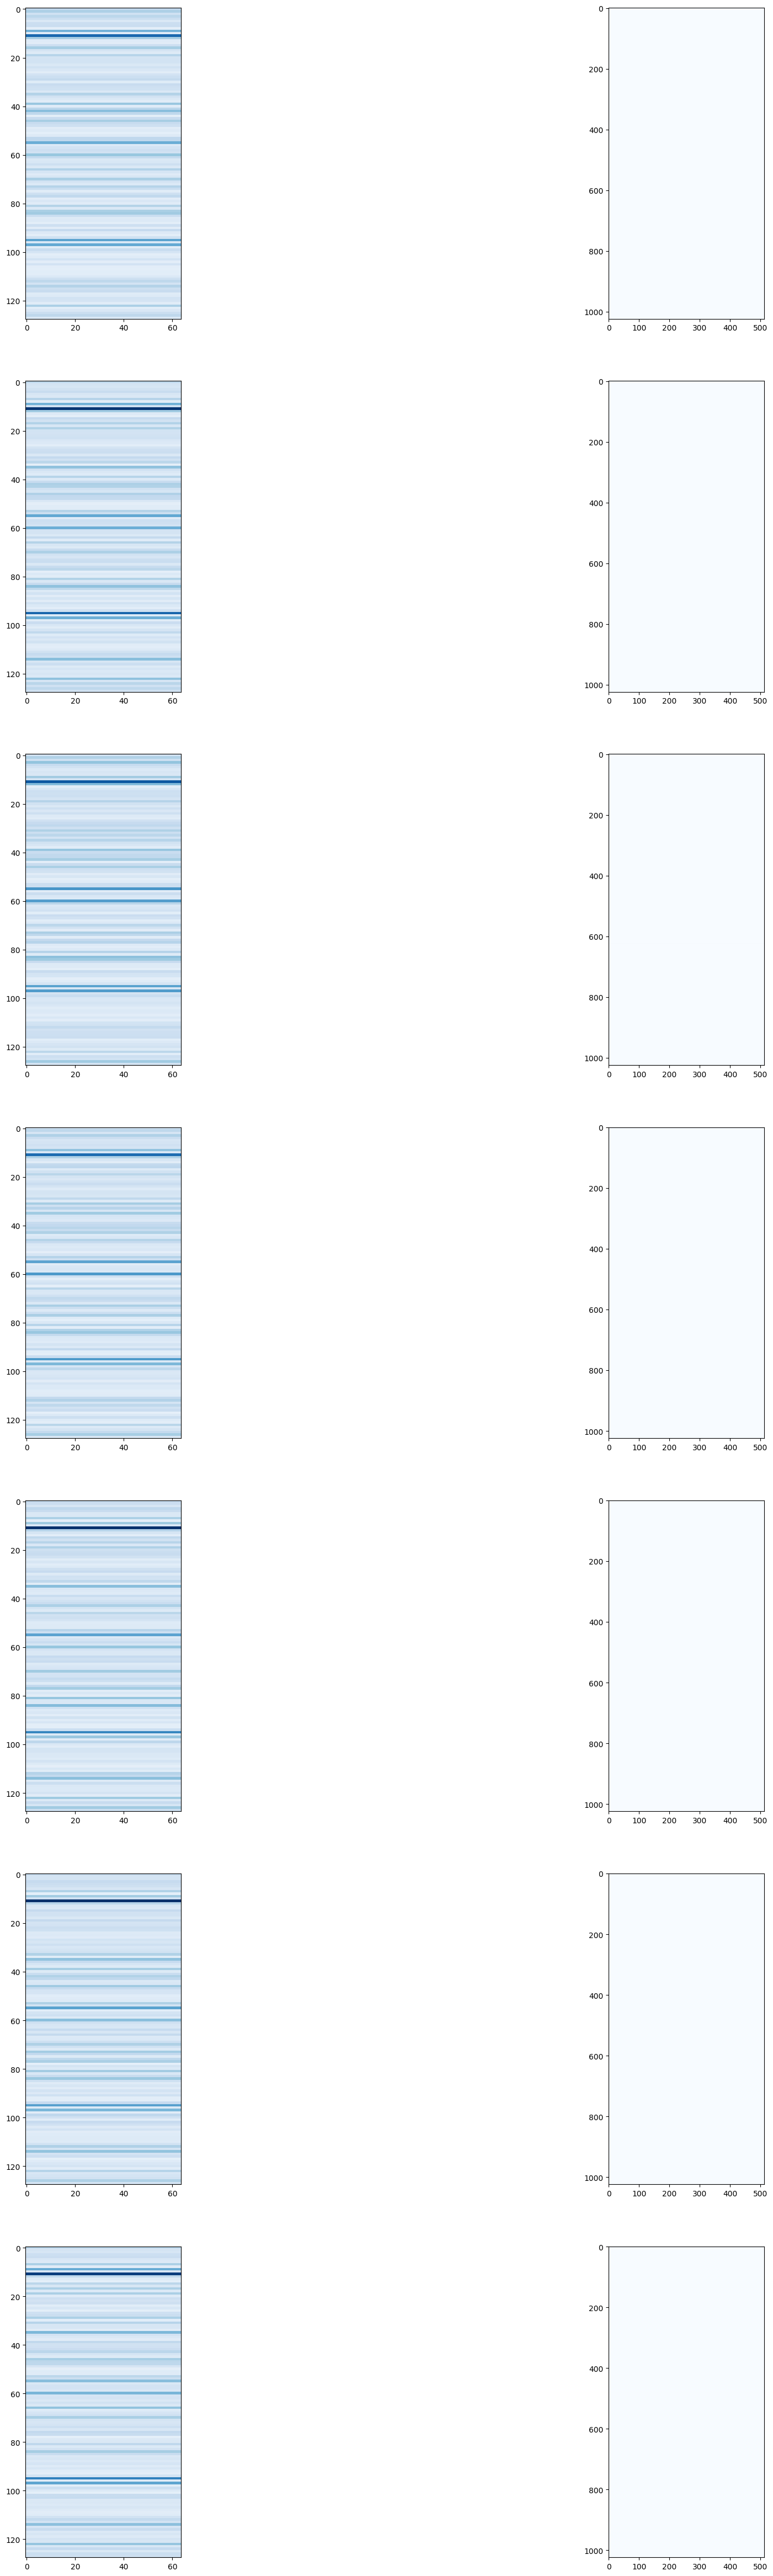

In [85]:
d = "01"
number_of_rows = len(data[e][d]["Network"])
# number_of_rows = 3

fig, ax = plt.subplots(nrows=number_of_rows, ncols=2, figsize=(25, 60))
for j in range(number_of_rows):
  show_active_prime = []
  k = 0
  for i, active in enumerate(activations[d][j]):
    show_active = np.repeat(active[:, np.newaxis], len(active)/2, axis=1)
    show_active_prime.append(show_active)
    if i == 0:
      show_active_prime = []
    if i == 1 or i == len(activations[d][j])-1 or i == len(activations[d][j]) - 2:
      ax[j][k].imshow(np.concatenate(show_active_prime, axis=1), cmap='Blues', interpolation='nearest', vmin=x_min, vmax=x_max)
      show_active_prime = []
      k += 1

output_path = os.path.join(output_dir, f"Acrobot_heatmap_{d}.png")
plt.savefig(output_path, bbox_inches="tight")

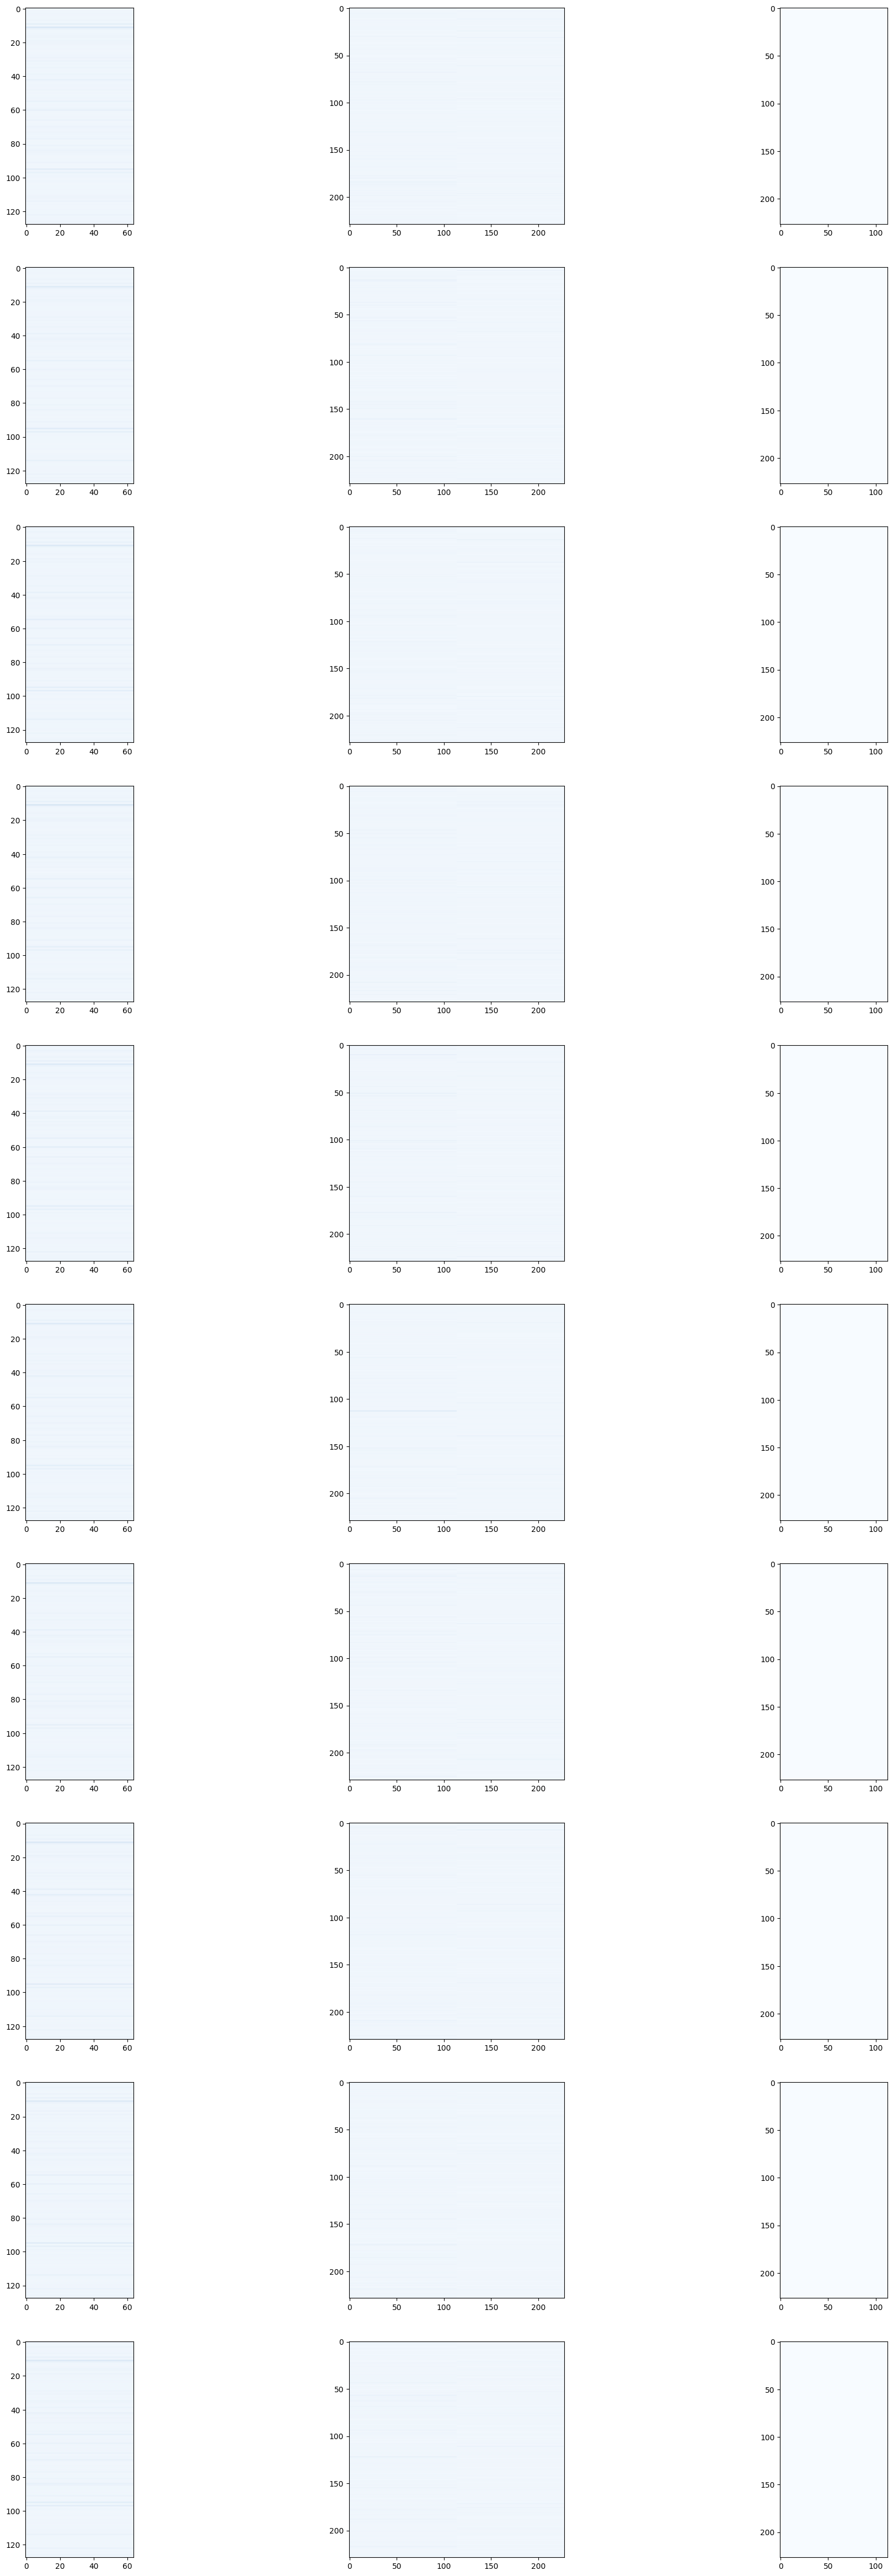

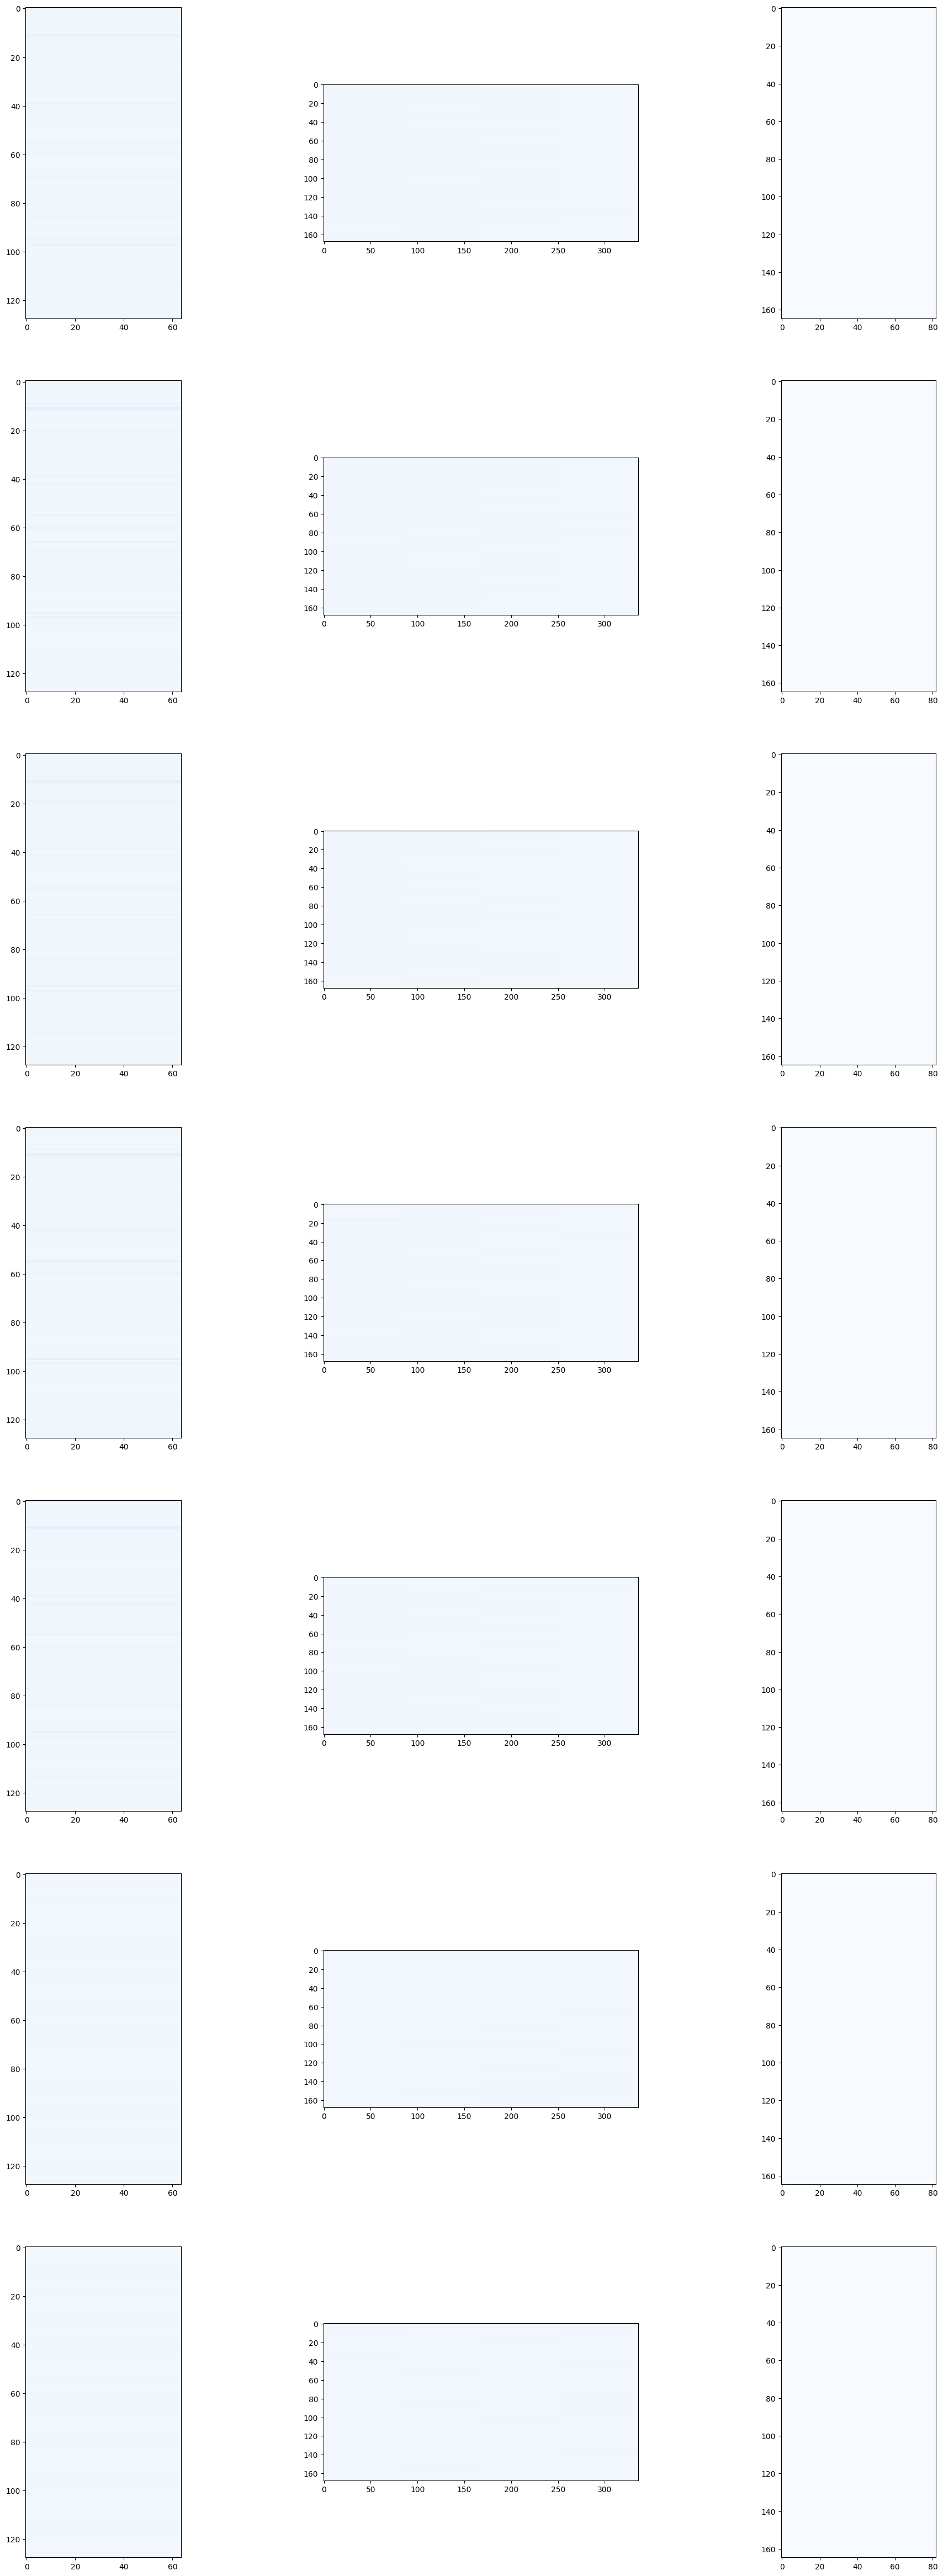

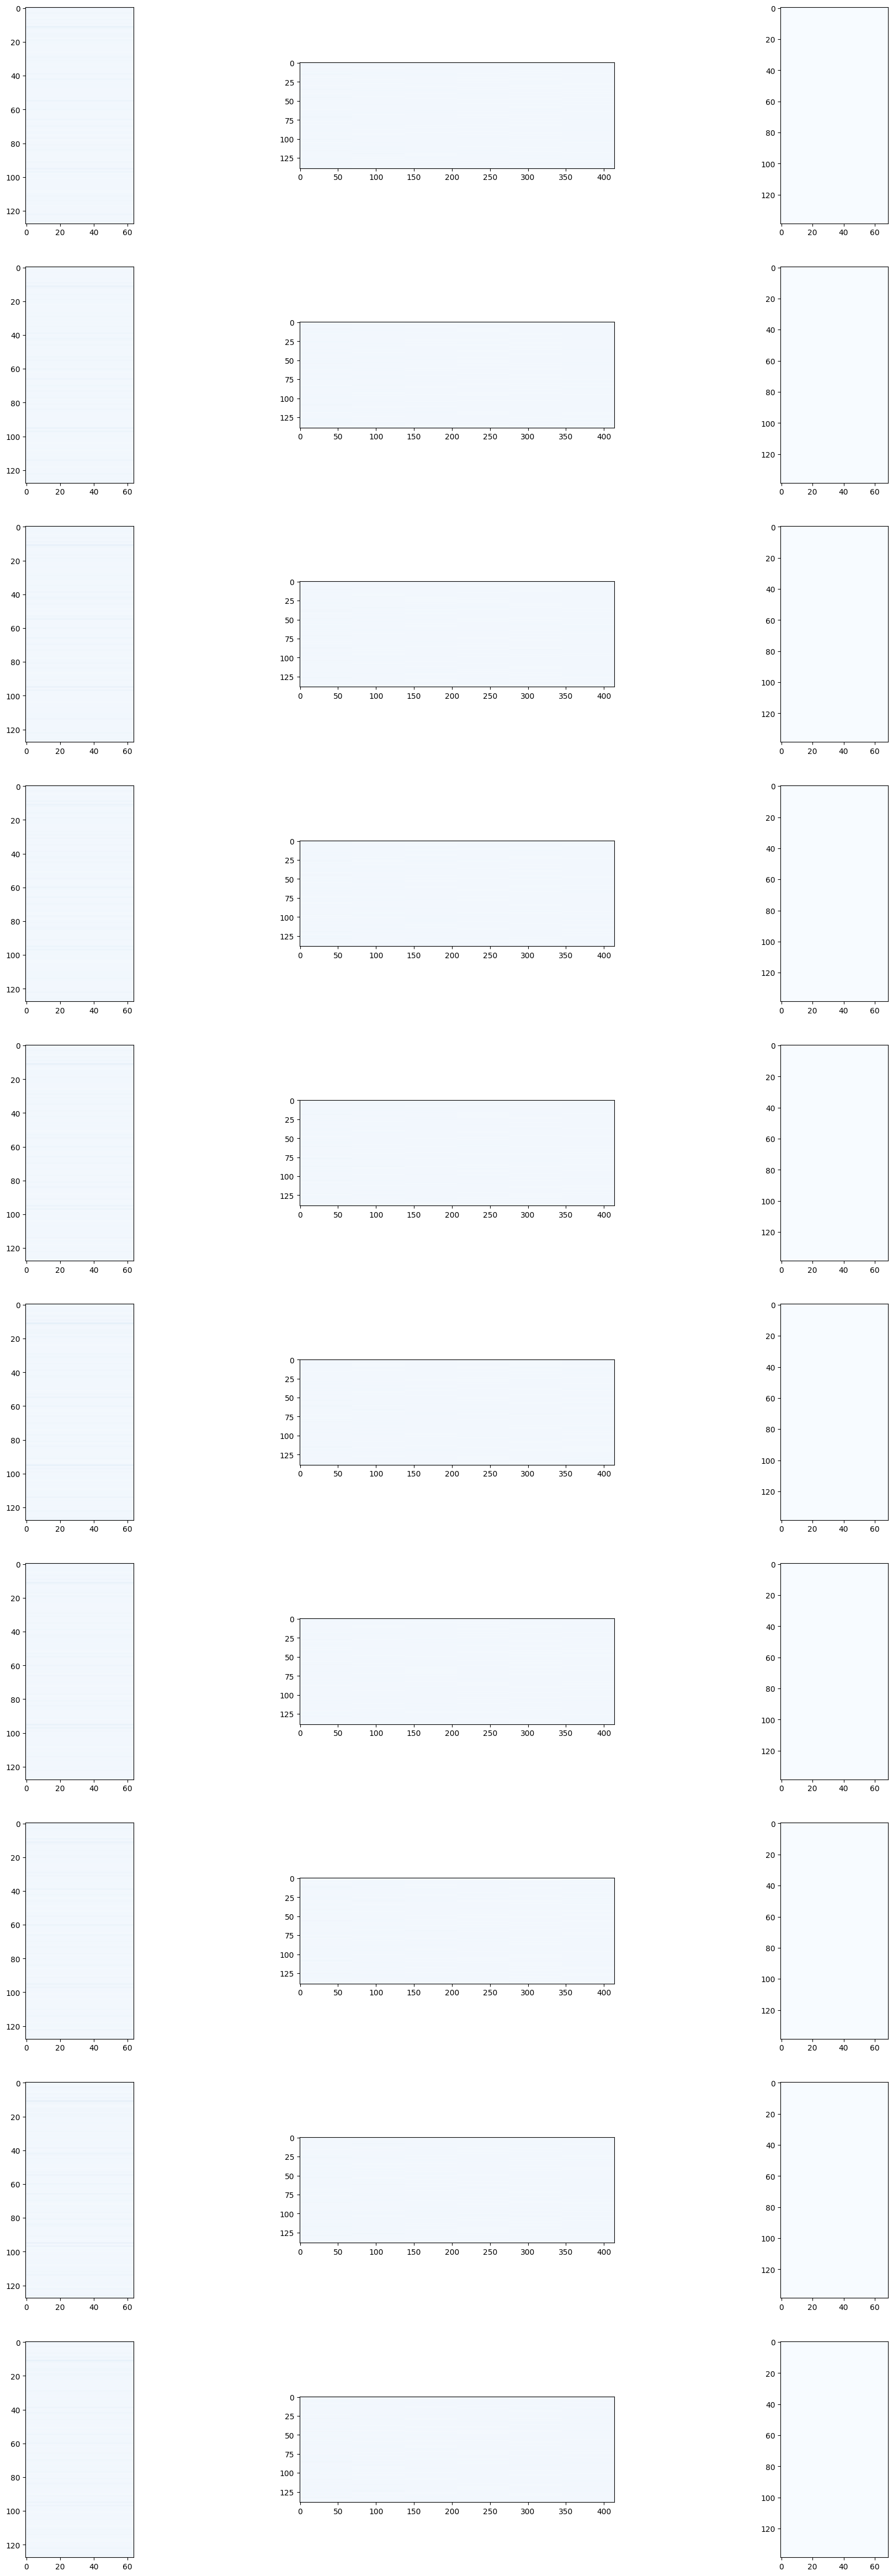

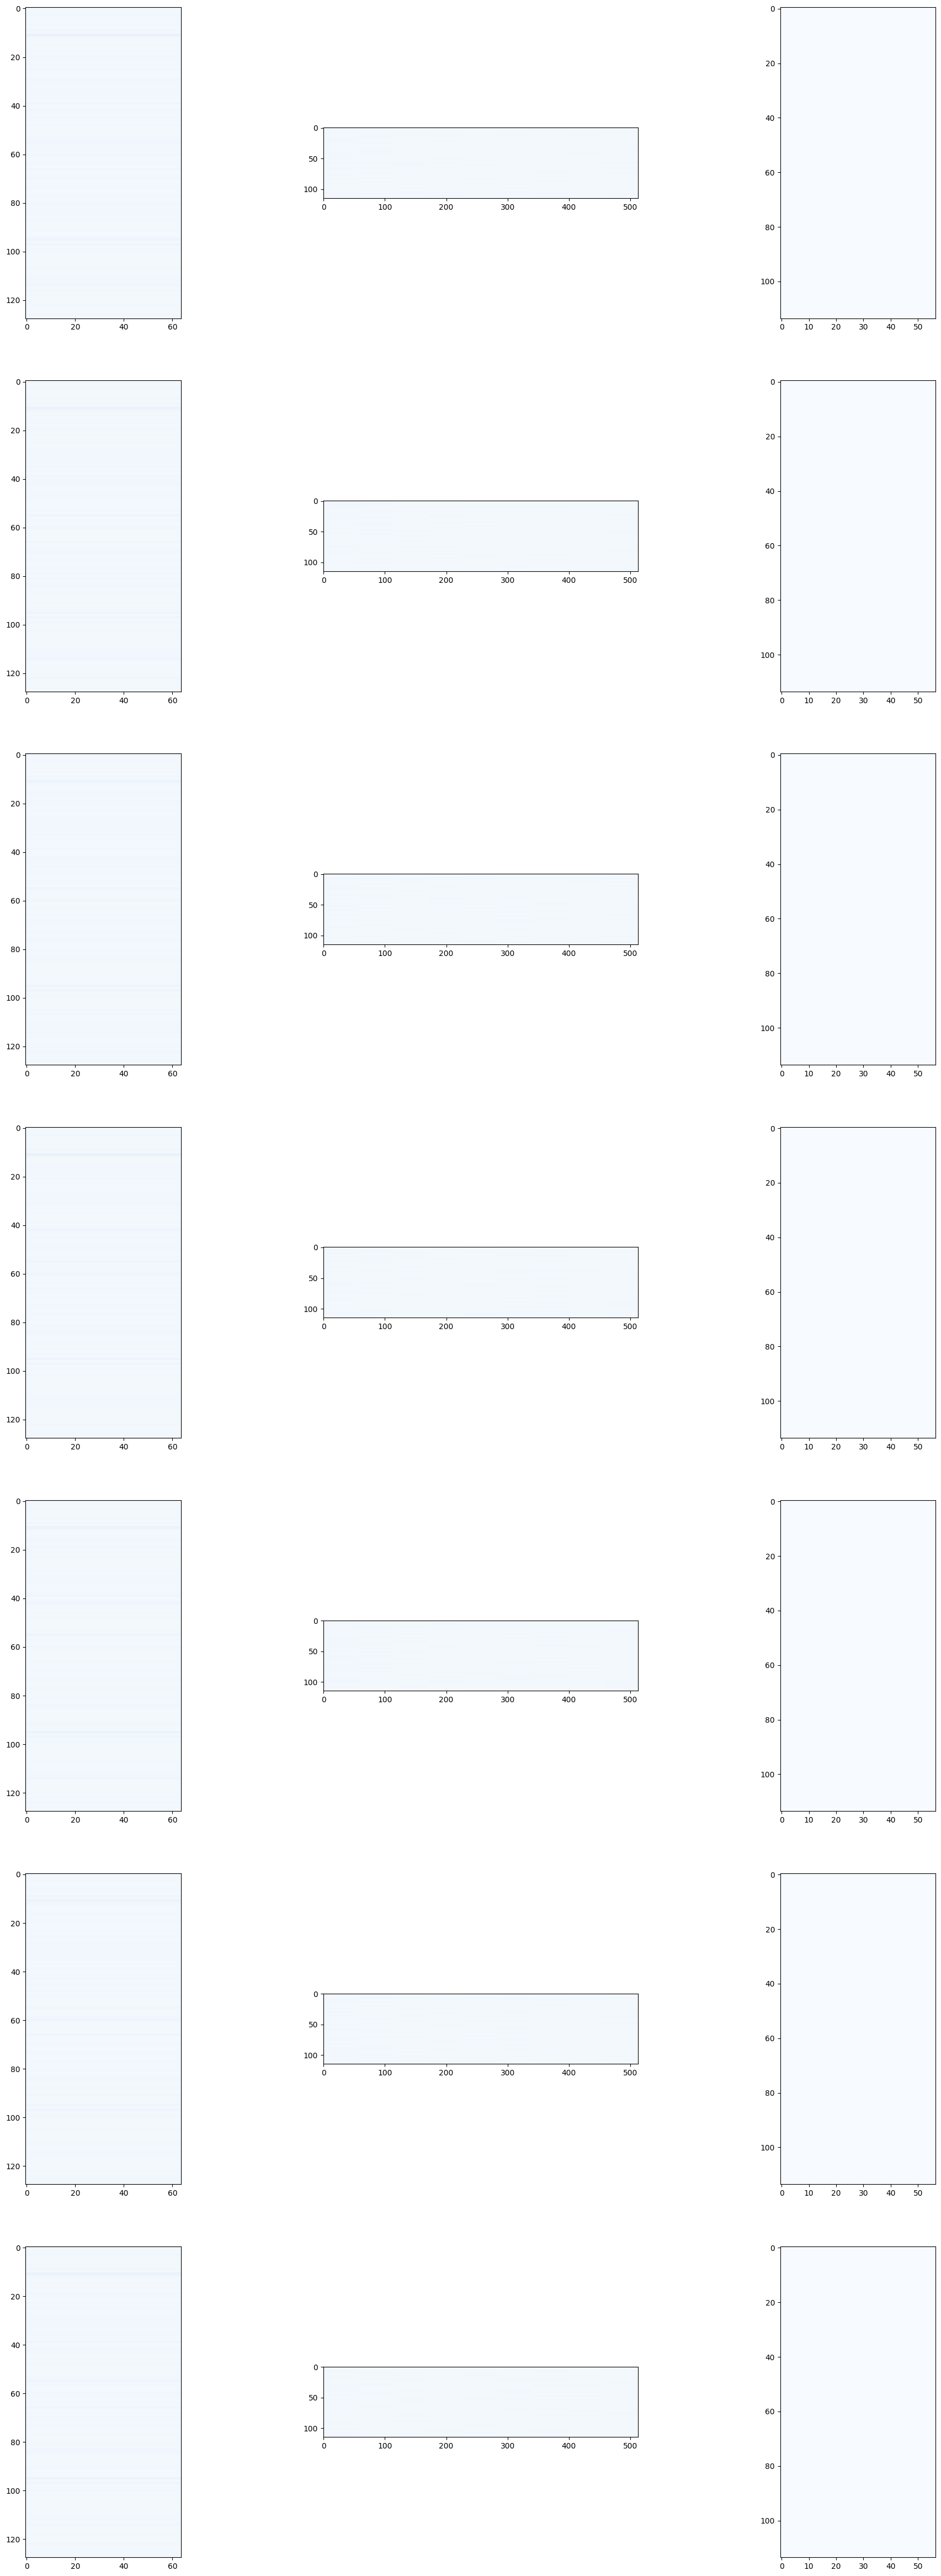

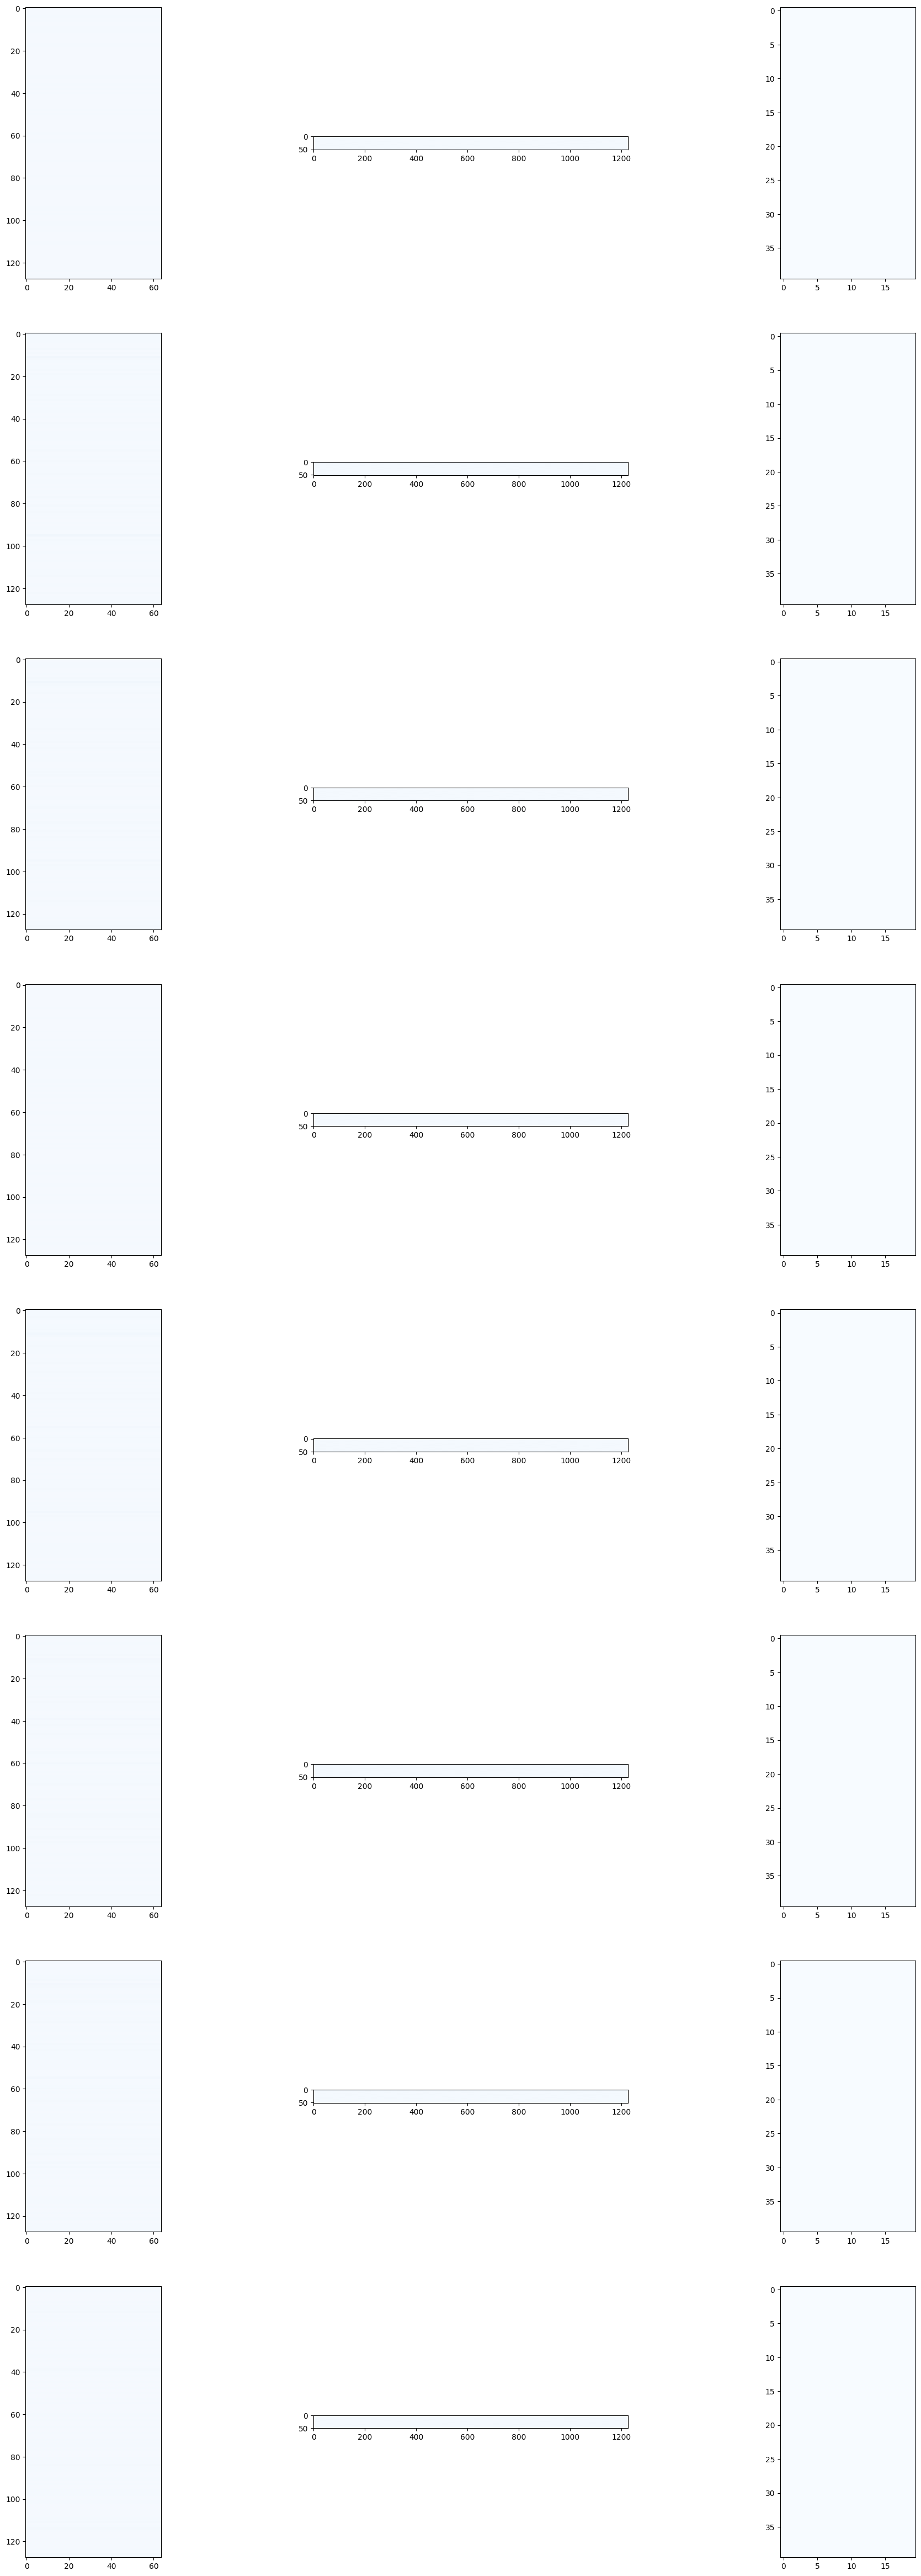

In [86]:
# d = "03"
for d in ['03', '05', '07', '10', '50']:
  number_of_rows = len(data[e][d]["Network"])
  # number_of_rows = 3

  fig, ax = plt.subplots(nrows=number_of_rows, ncols=3, figsize=(25, 60))
  for j in range(number_of_rows):
    show_active_prime = []
    k = 0
    for i, active in enumerate(activations[d][j]):
      show_active = np.repeat(active[:, np.newaxis], len(active)/2, axis=1)
      show_active_prime.append(show_active)
      if i == 0:
        show_active_prime = []
      if i == 1 or i == len(activations[d][j])-1 or i == len(activations[d][j]) - 2:
        ax[j][k].imshow(np.concatenate(show_active_prime, axis=1), cmap='Blues', interpolation='nearest', vmin=x_min, vmax=x_max)
        show_active_prime = []
        k += 1

  output_path = os.path.join(output_dir, f"Acrobot_Heatmap_{d}.png")
  plt.savefig(output_path, bbox_inches="tight")

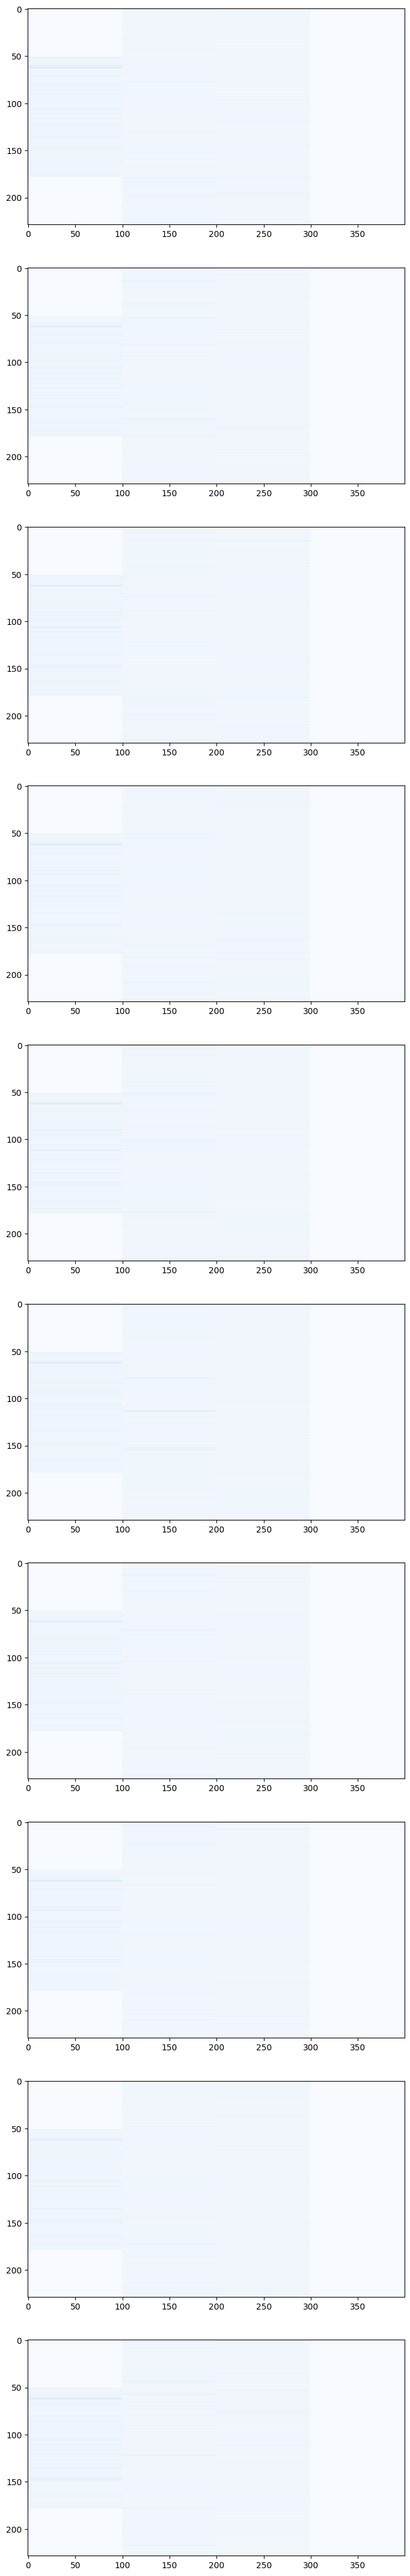

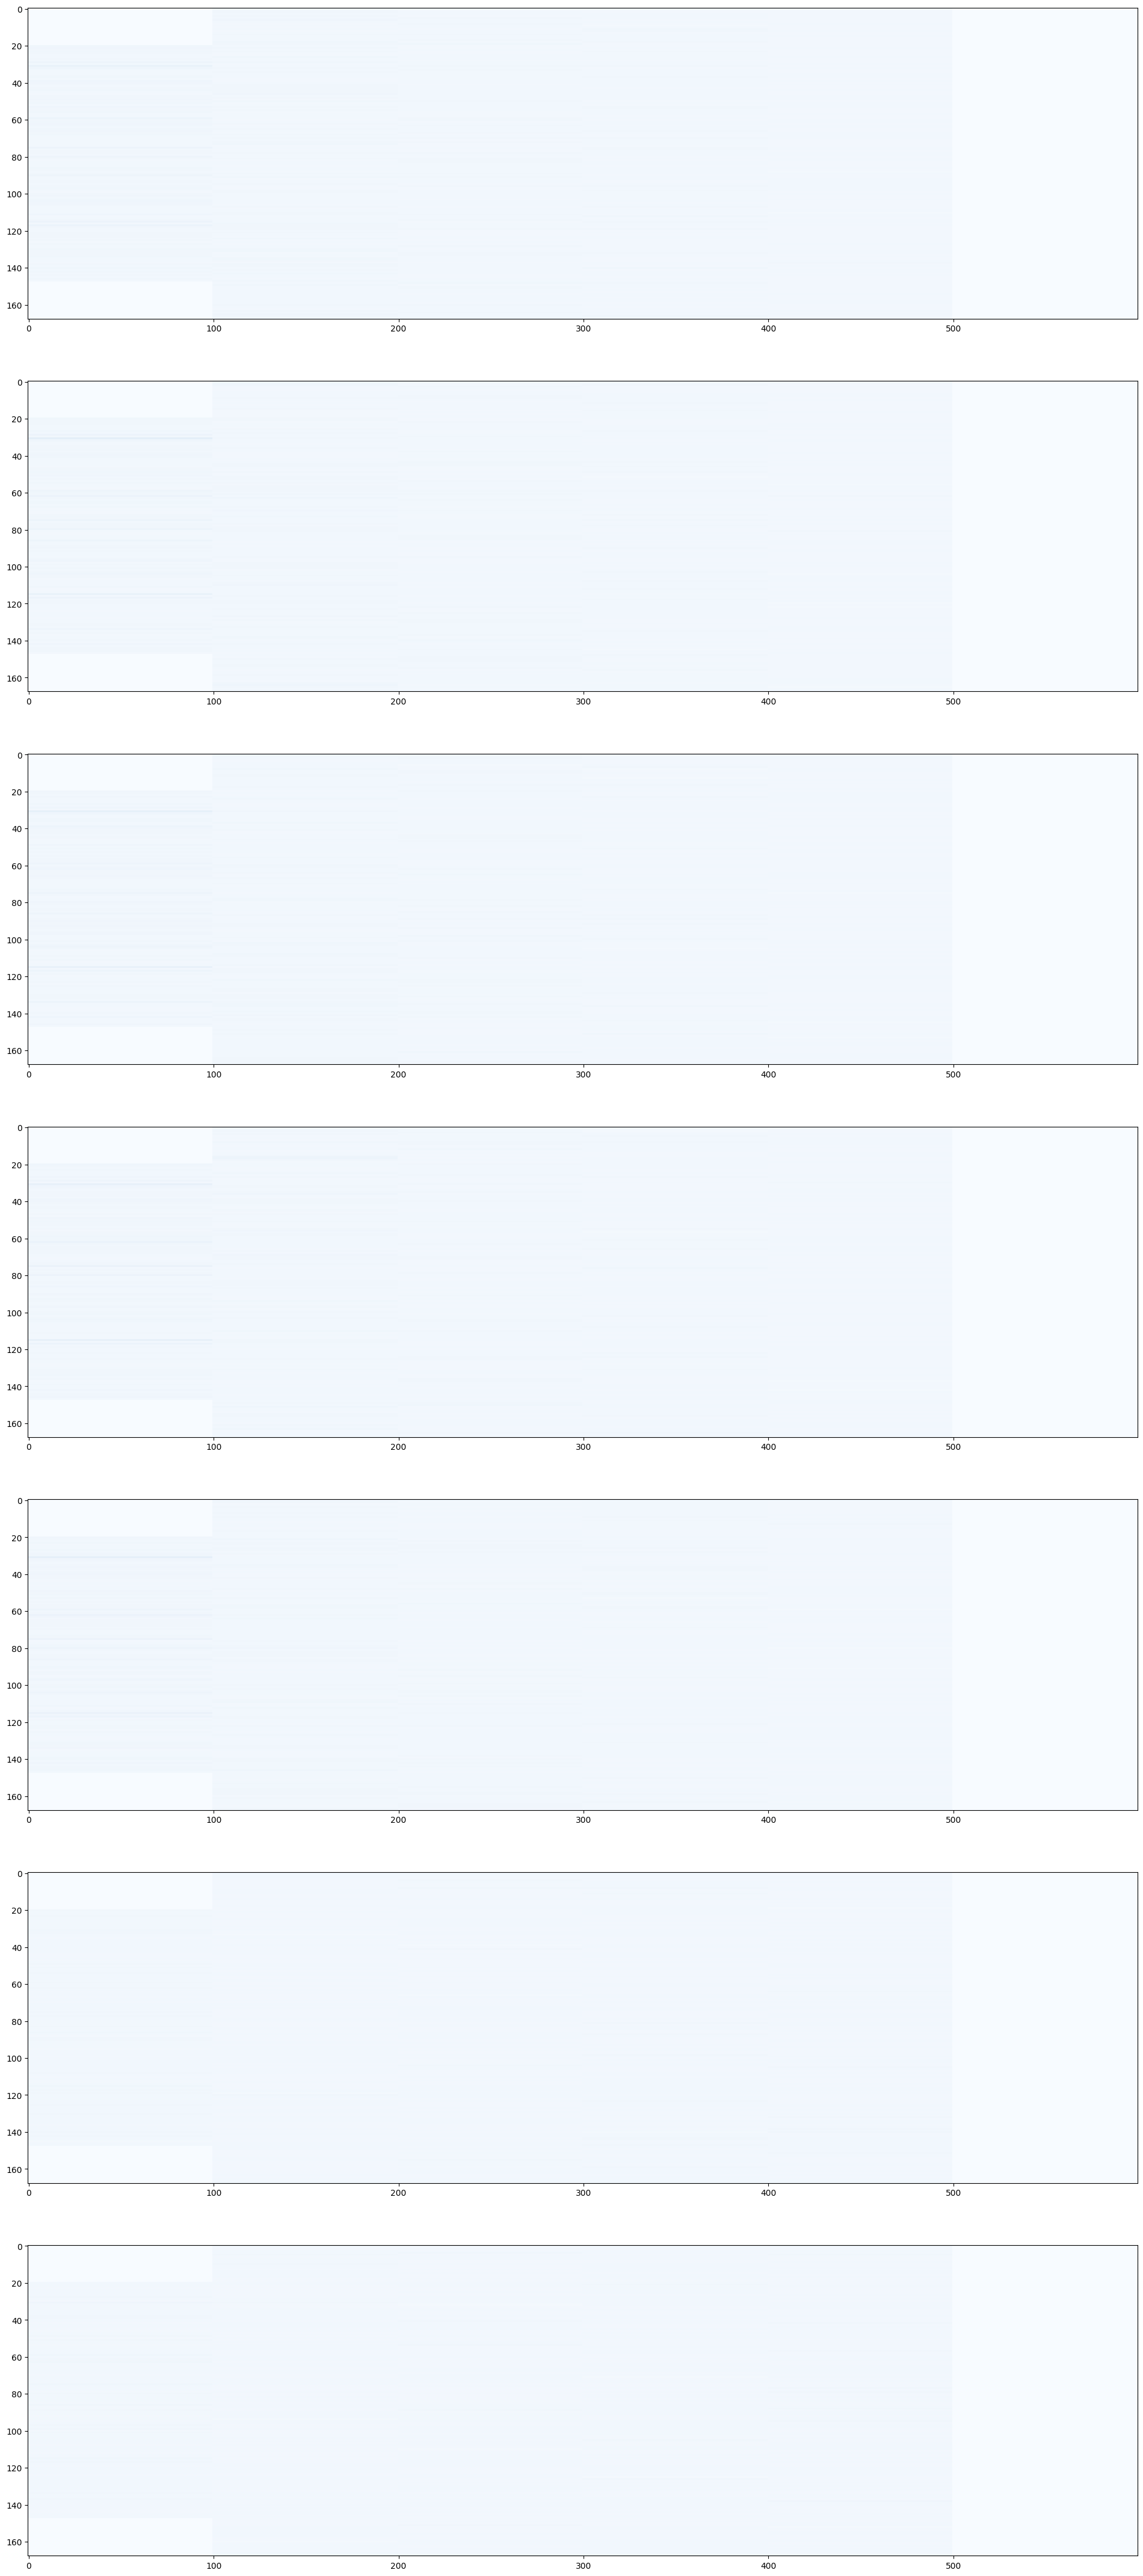

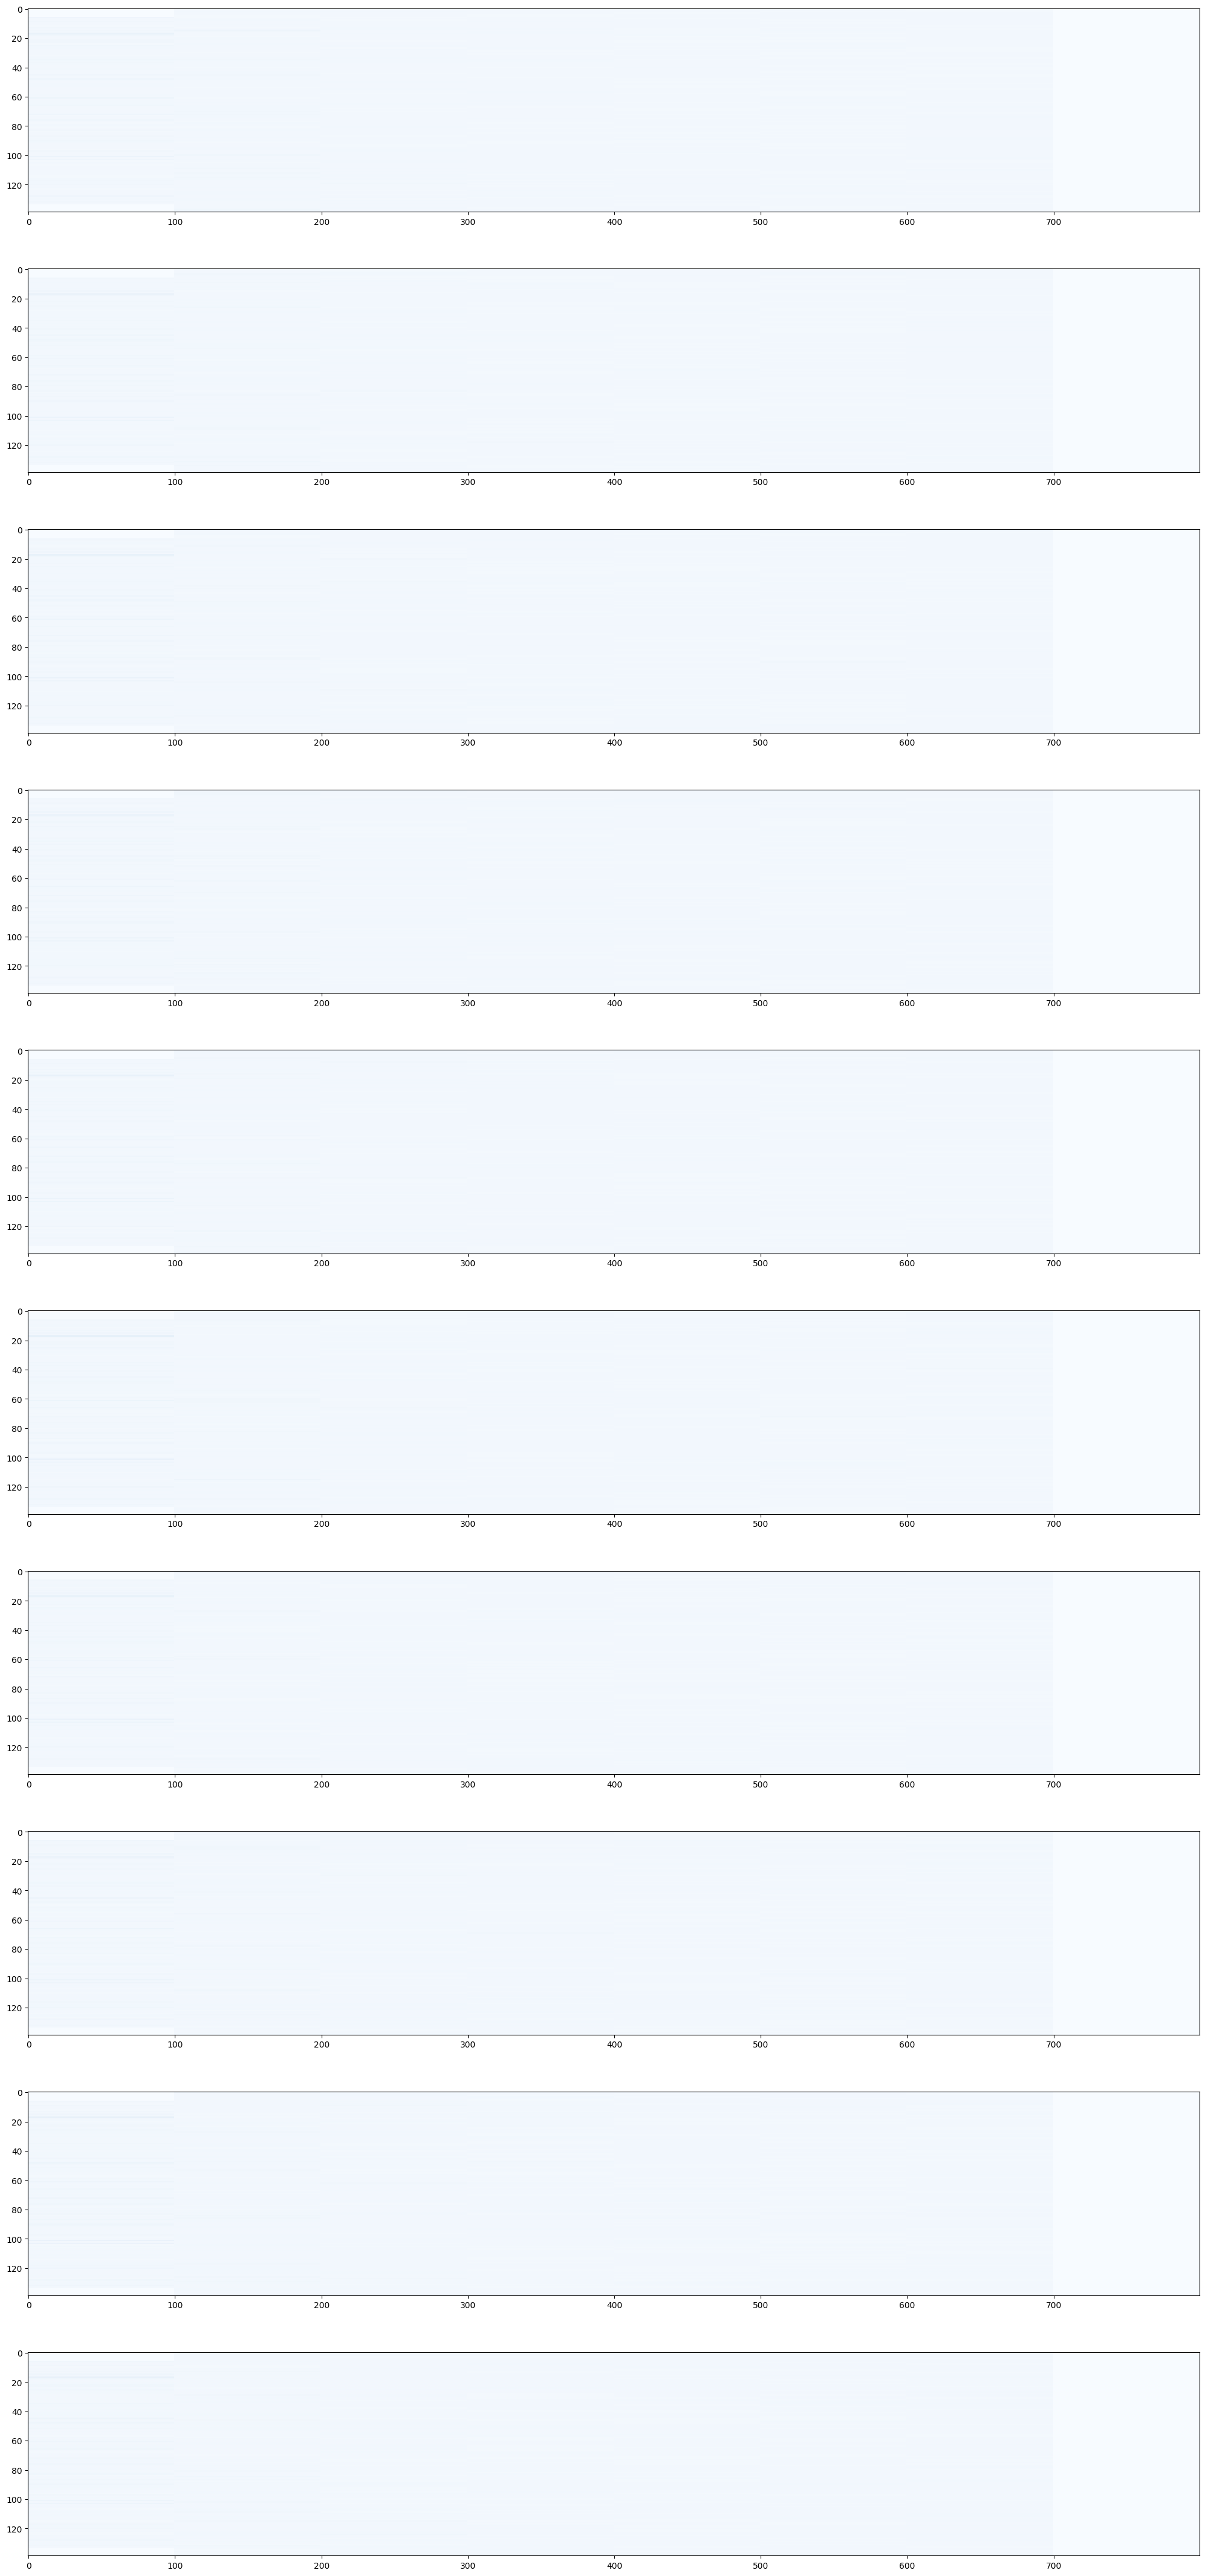

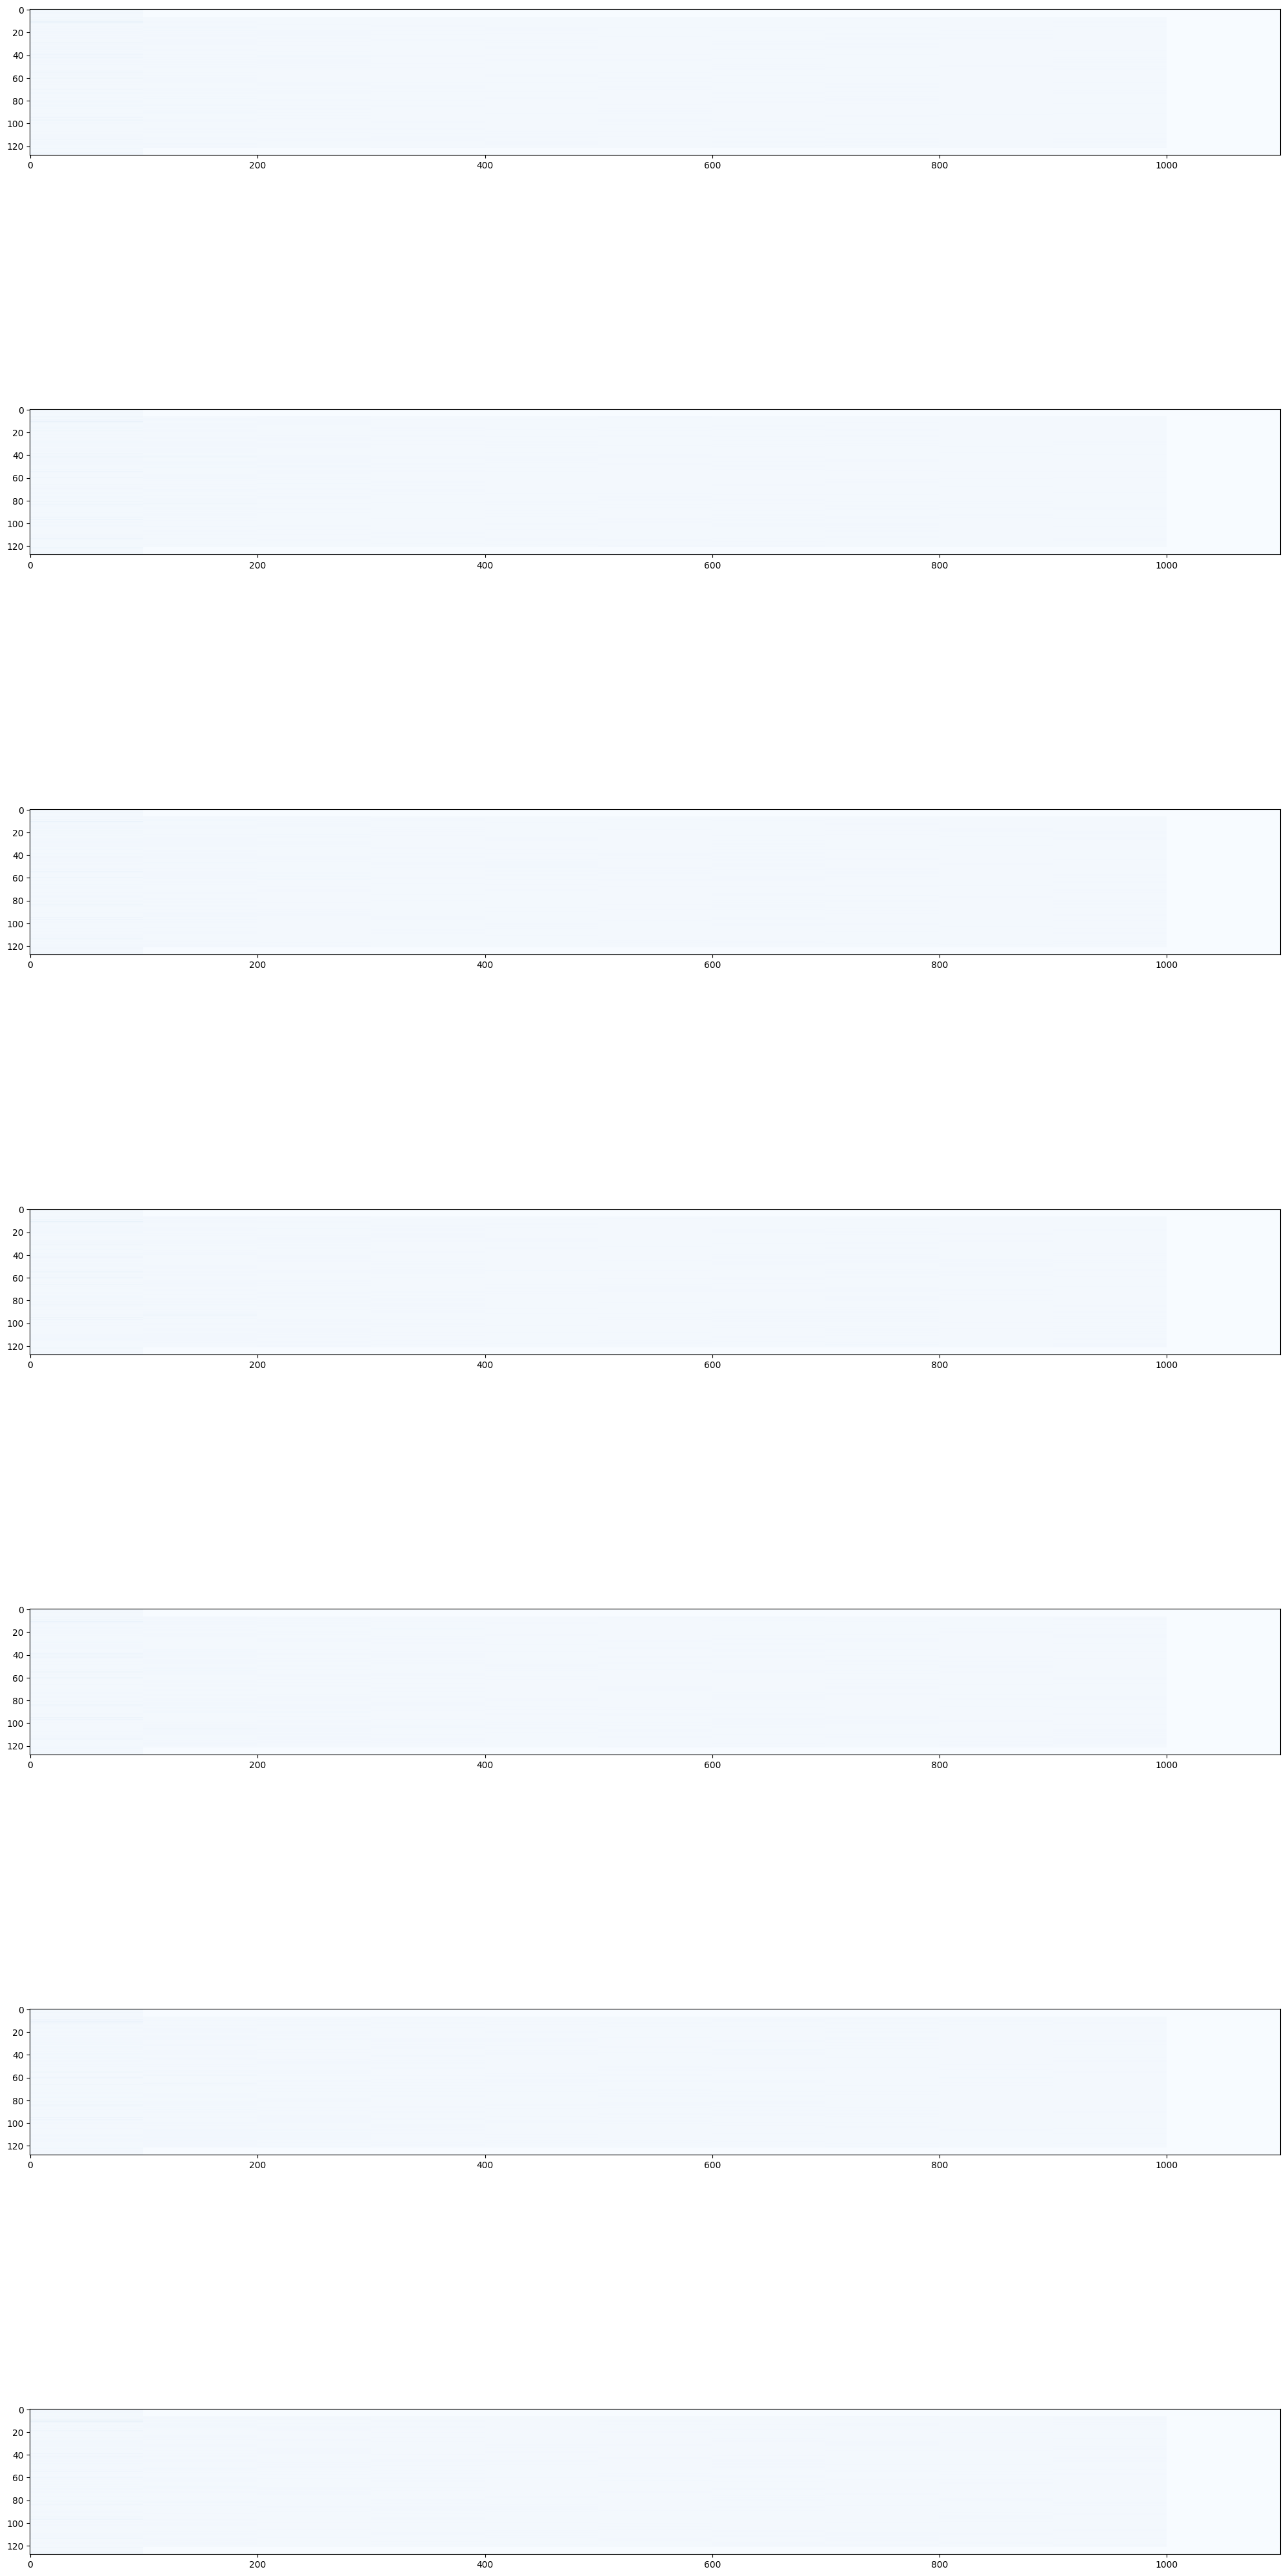

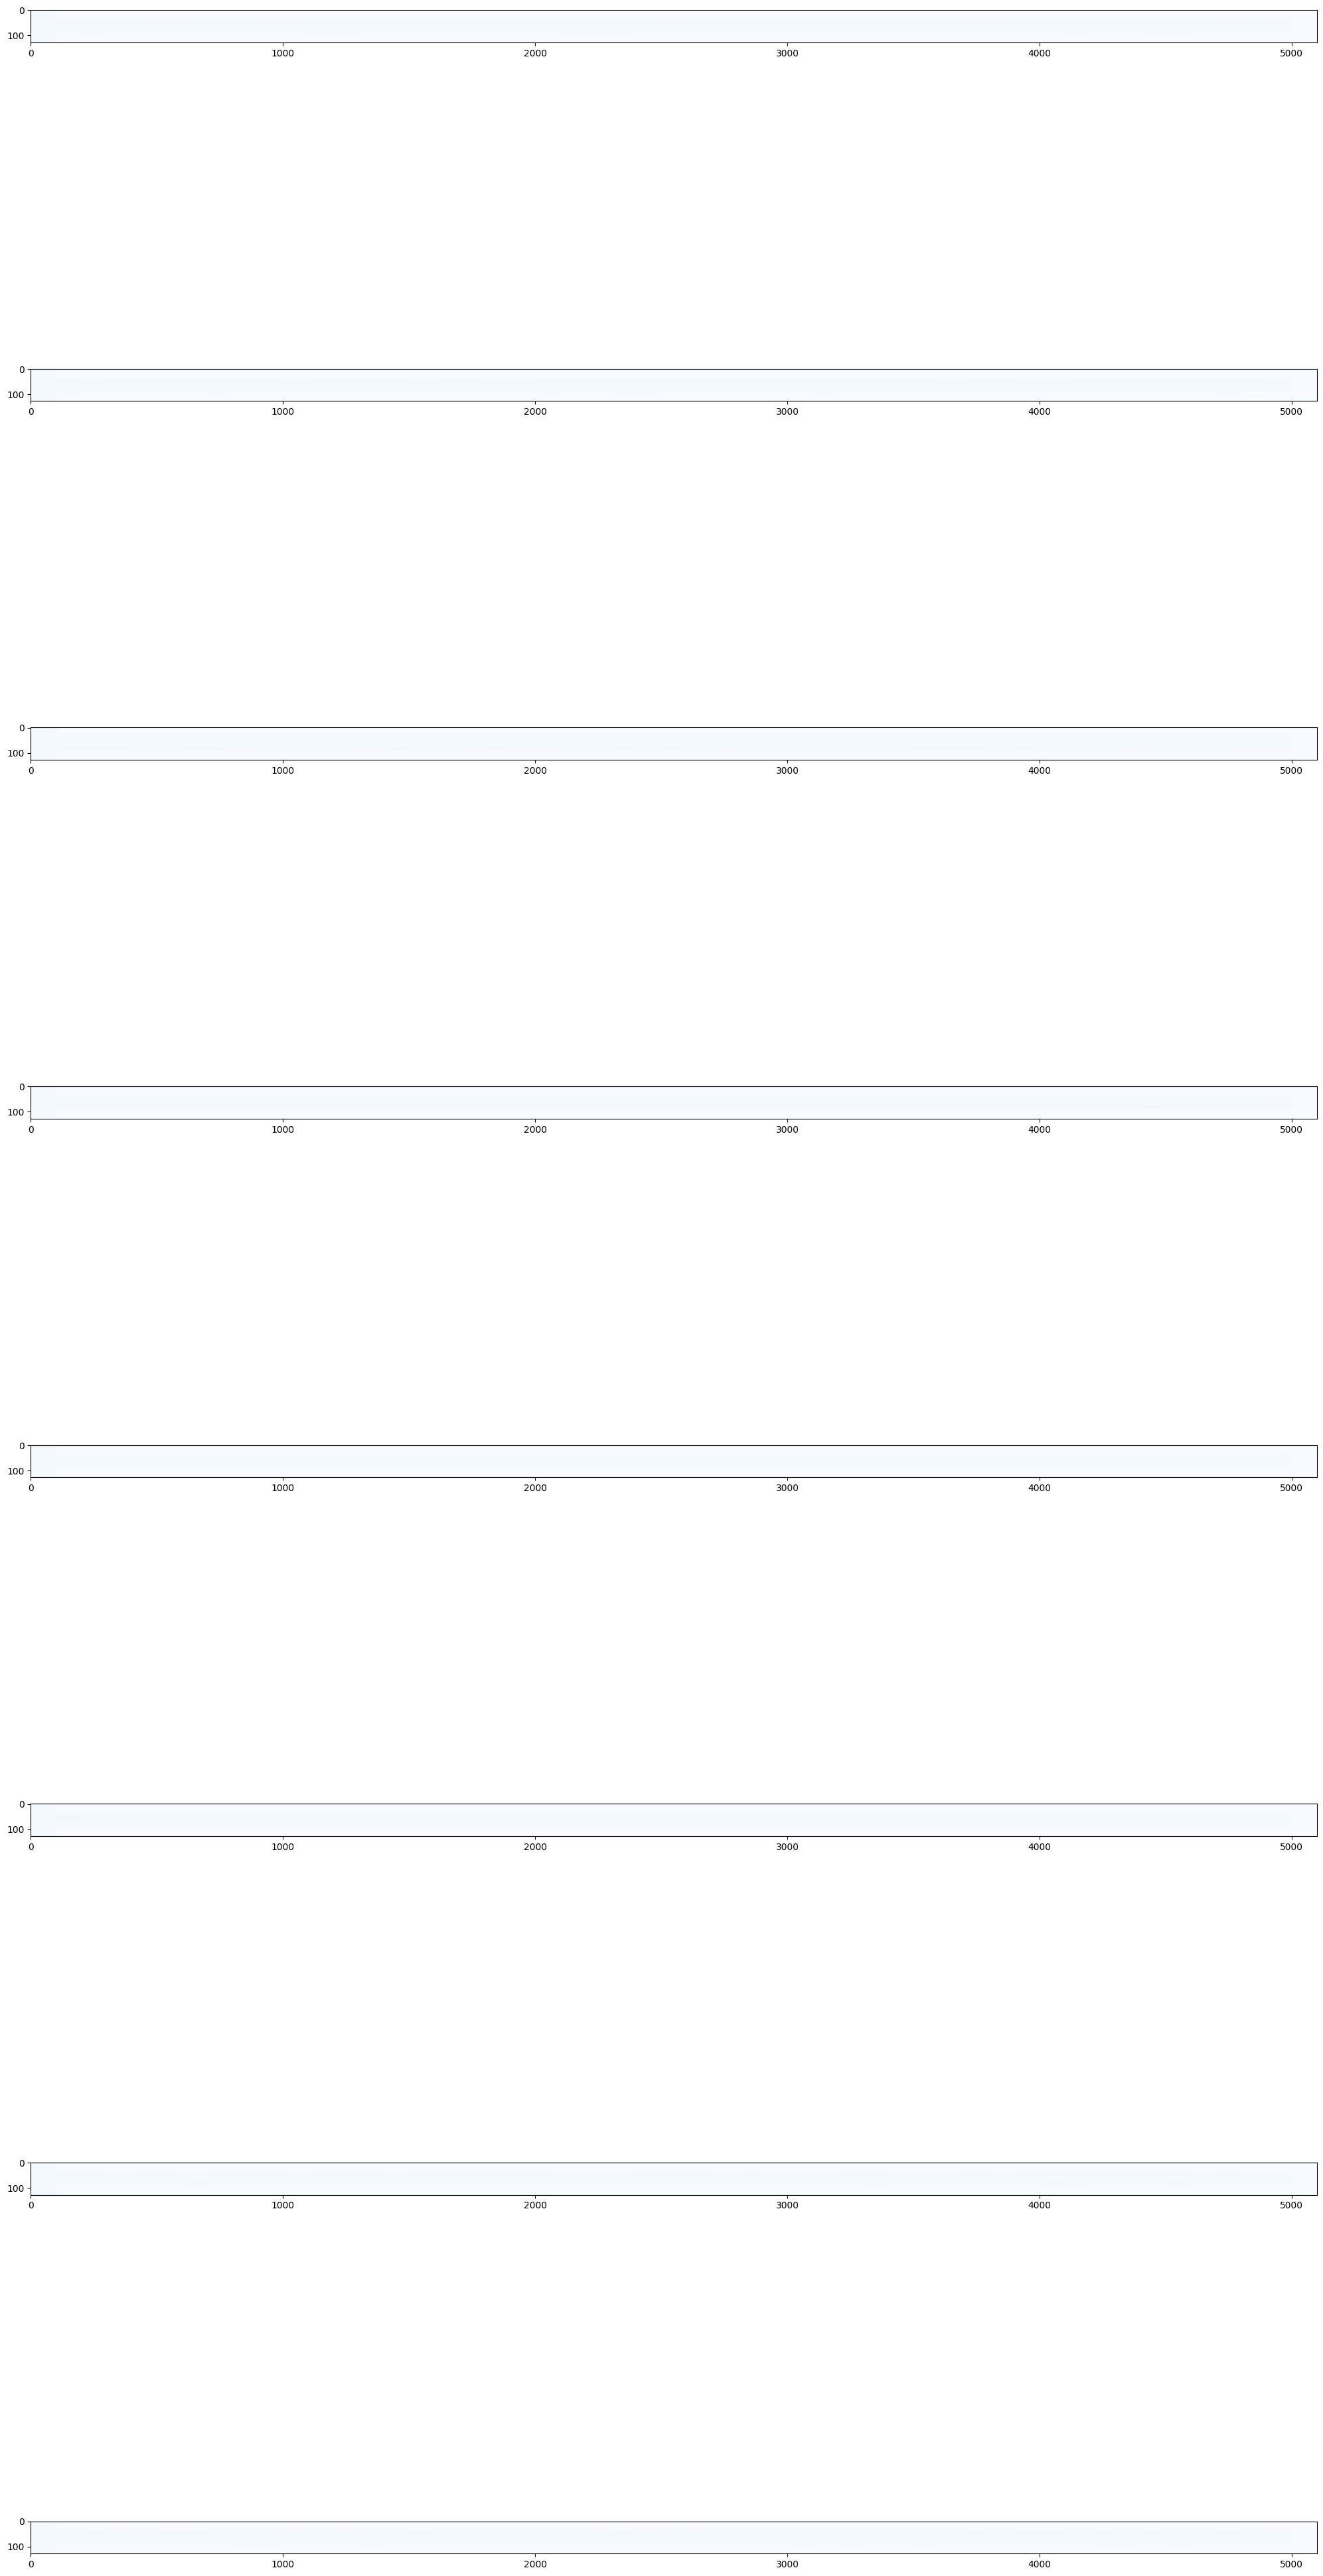

In [87]:
# d = "05"
for d in ['03', '05', '07', '10', '50']:

  number_of_rows = len(data[e][d]["Network"])
  # number_of_rows = 3

  fig, ax = plt.subplots(nrows=number_of_rows, ncols=1, figsize=(25, 55))

  for j in range(number_of_rows):
    show_active_prime = []
    k = 0
    show_size = 0
    for i, active in enumerate(activations[d][j]):
      show_active = np.repeat(active[:, np.newaxis], 100, axis=1)
      show_active_prime.append(show_active)
      show_size = max(show_size, len(show_active))
      if i == 0:
        show_active_prime = []
        show_size = 0

    #print(show_size)
    final_show = []
    for show in show_active_prime:
      if show.shape[1] < show_size:
        gap = (show_size - show.shape[0])
        gap_p = int(gap / 2)
        #print(show_size, show.shape, gap)
        if gap == 0:
          t = show
        else:
          if gap % 2 == 1:
            t = np.concatenate([np.zeros((gap_p + 1, show.shape[1])), show, np.zeros((gap_p, show.shape[1]))], axis=0)
          else:
            t = np.concatenate([np.zeros((gap_p, show.shape[1])), show, np.zeros((gap_p, show.shape[1]))], axis=0)
        #print(t.shape)
        final_show.append(t)
    ax[j].imshow(np.concatenate(final_show, axis=1), cmap='Blues', interpolation='nearest', vmin=x_min, vmax=x_max)

    output_path = os.path.join(output_dir, f"Acrobot_Heatmap_{d}_single.png")
    plt.savefig(output_path, bbox_inches="tight")

# Save Plots

In [33]:
!ls

'01 - Hamid'   '04 - Mamrez'  '07 - Mamrez'  '10 - Hamid'   Acrobot	  Draft		   Plots
'02 - Mamrez'  '05 - Hamid'   '08 - Mamrez'  '20 - Hamid'   Acrobot_New   gym_gridworlds
'03 - Hamid'   '06 - Mamrez'  '09 - Mamrez'  '50 - Hamid'   CartPole	  Heatmaps


In [31]:
len(networks)

6

In [47]:
seed = 0
d = '07'
f"Acrobat_DQN_{d}_{seed}.json"

'Acrobat_DQN_07_0.json'

In [50]:
os.path.exists(f"{d} - Mamrez/Acrobat_DQN_{d}_{seed}.json")

True

In [53]:
data_plots = {}

for network in networks:
  data_plots[network] = {"loss": [], "train_reward": [], "eval_reward": []}

len(data_plots)

In [55]:
networks[0]

QNetwork(
  (feature_layer): Linear(in_features=6, out_features=128, bias=True)
  (layers): ModuleList(
    (0): Linear(in_features=128, out_features=1024, bias=True)
  )
  (final_layer): Linear(in_features=1024, out_features=3, bias=True)
)

In [56]:
import json
for i, d in enumerate(['01', '03', '05', '07', '10', '50']):

  network = networks[i]

  for seed in range(10):

    if d == "07":
      filename = f"{d} - Mamrez/Acrobat_DQN_{d}_{seed}.json"
    else:
      filename = f"{d} - Hamid/Acrobat_DQN_{d}_{seed}.json"

    with open(filename, 'r') as f:
      loaded_data = json.load(f)

    data_plots[network]["loss"].append(loaded_data["loss"])
    data_plots[network]["train_reward"].append(loaded_data["train_reward"])
    data_plots[network]["eval_reward"].append(loaded_data["eval_reward"])

In [58]:
for network in networks:
  print(len(data_plots[network]['loss']), end=' ')

10 10 10 10 10 10 

In [72]:
netwrok_names = [f"DQN_{depths[i]:02}_{fc_units[i]}_{sum(p.numel() for p in networks[i].parameters())}" for i in range(len(depths))]
network_names = [f"DQN_{depths[i]:02}_{fc_units[i]}_{sum(p.numel() for p in networks[i].parameters())}" for i in range(len(depths))]
netwrok_names

['DQN_01_1024_136067',
 'DQN_03_229_136001',
 'DQN_05_168_136127',
 'DQN_07_139_136007',
 'DQN_10_115_136020',
 'DQN_50_51_136974']

In [70]:
for loss in data_plots[network]["loss"]:
  for l in loss:
    print(type(l), l)
    break

<class 'float'> 3.1387743949890137
<class 'float'> 3.017693519592285
<class 'float'> 3.3134748935699463
<class 'float'> 3.6579010486602783
<class 'float'> 3.8489208221435547
<class 'float'> 4.104710102081299
<class 'float'> 3.809068441390991
<class 'float'> 3.4998779296875
<class 'float'> 2.7865006923675537
<class 'float'> 3.240872383117676


In [71]:
len(data_plots[network]["train_reward"])

10

In [78]:
type(depths_)

list

In [79]:
output_directory_plots = "Plots"

In [84]:
import os
import numpy as np
import matplotlib.pyplot as plt

for i, network in enumerate(networks):
    fig, ax = plt.subplots(ncols=3, figsize=(21, 7))

    losses = [
        [0 if isinstance(l, int) else (l if isinstance(l, float) else l.cpu().detach().numpy()) for l in loss]
        for loss in data_plots[network]["loss"]
    ]
    max_loss_length = max(len(loss) for loss in losses)
    losses = np.array([np.pad(loss, (0, max_loss_length - len(loss)), constant_values=0) for loss in losses])

    rewards = data_plots[network]["train_reward"]
    max_reward_length = max(len(r) for r in rewards)
    rewards = np.array([np.pad(r, (0, max_reward_length - len(r)), constant_values=0) for r in rewards])

    eval_rewards = data_plots[network]["eval_reward"]
    max_eval_length = max(len(r) for r in eval_rewards)
    eval_rewards = np.array([np.pad(r, (0, max_eval_length - len(r)), constant_values=0) for r in eval_rewards])

    min_loss = losses.min(axis=0)
    max_loss = losses.max(axis=0)
    mean_loss = losses.mean(axis=0)

    x = np.arange(len(mean_loss))
    ax[0].plot(x, mean_loss, '-')
    ax[0].fill_between(x, min_loss, max_loss, alpha=0.7)

    min_eval_reward = eval_rewards.min(axis=0)
    max_eval_reward = eval_rewards.max(axis=0)
    mean_eval_reward = eval_rewards.mean(axis=0)

    x = np.arange(len(mean_eval_reward))
    ax[1].plot(x, mean_eval_reward, '-')
    ax[1].fill_between(x, min_eval_reward, max_eval_reward, alpha=0.7)

    min_reward = rewards.min(axis=0)
    max_reward = rewards.max(axis=0)
    mean_reward = rewards.mean(axis=0)

    x = np.arange(len(mean_reward))
    ax[2].plot(x, mean_reward, '-')
    ax[2].fill_between(x, min_reward, max_reward, alpha=0.7)

    ax[0].set_title(f"{network_names[i]} loss")
    ax[1].set_title(f"{network_names[i]} eval reward")
    ax[2].set_title(f"{network_names[i]} train reward")

    ax[0].set_xlabel("Episode")
    ax[1].set_xlabel("Episode")
    ax[2].set_xlabel("Episode")
    ax[0].set_ylabel("Loss")
    ax[1].set_ylabel("Eval Reward")
    ax[2].set_ylabel("Train Reward")

    plt.tight_layout()
    plt.show()

    output_path = os.path.join(output_directory_plots, f"Acrobot_Plot_{depths_[i]}.png")
    plt.savefig(output_path, dpi=300)
    plt.close(fig)


# Hamid's code

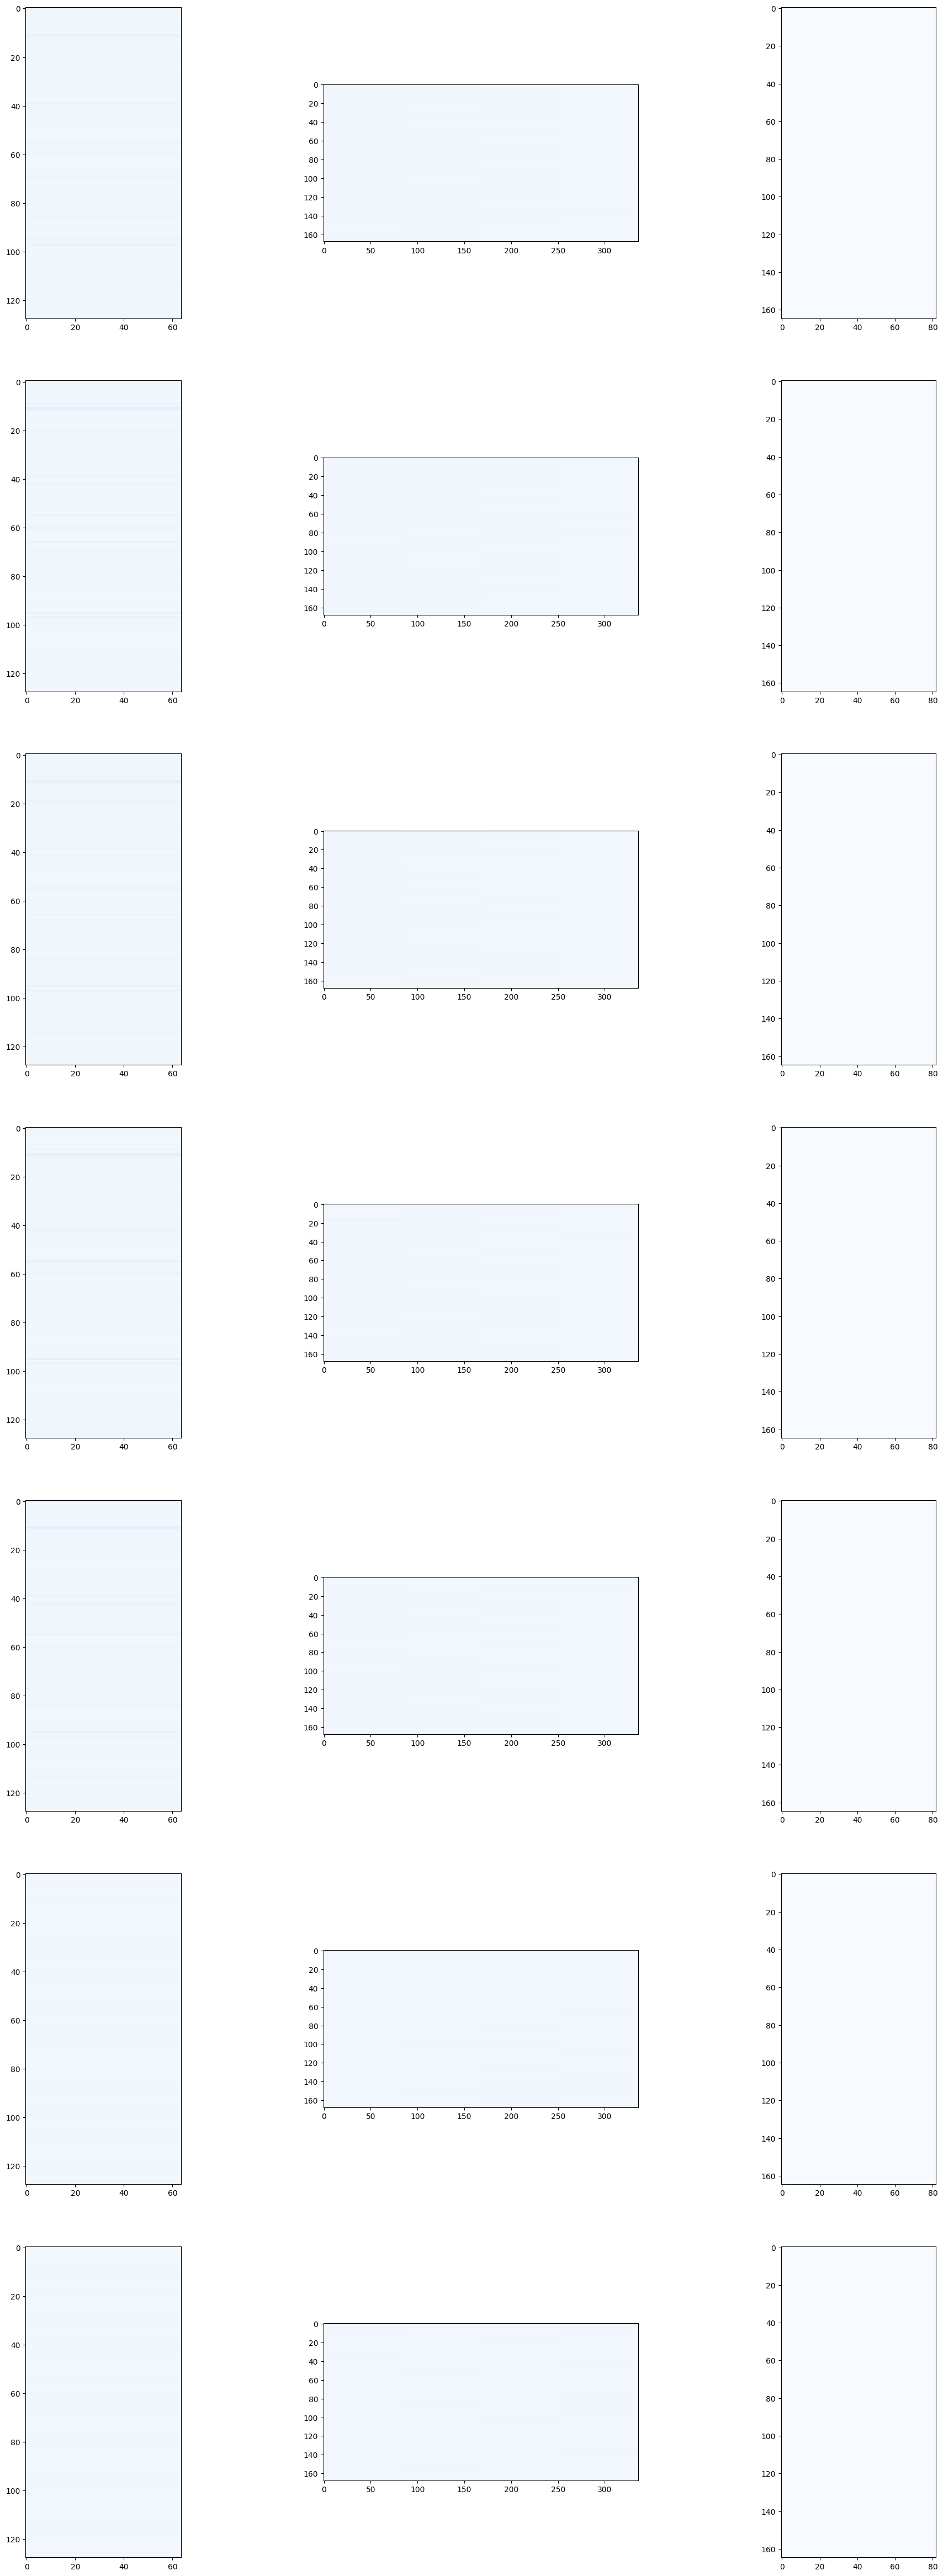

In [25]:
d = "05"
number_of_rows = len(data[e][d]["Network"])
# number_of_rows = 3

fig, ax = plt.subplots(nrows=number_of_rows, ncols=3, figsize=(25, 60))
for j in range(number_of_rows):
  show_active_prime = []
  k = 0
  for i, active in enumerate(activations[d][j]):
    show_active = np.repeat(active[:, np.newaxis], len(active)/2, axis=1)
    show_active_prime.append(show_active)
    if i == 0:
      show_active_prime = []
    if i == 1 or i == len(activations[d][j])-1 or i == len(activations[d][j]) - 2:
      ax[j][k].imshow(np.concatenate(show_active_prime, axis=1), cmap='Blues', interpolation='nearest', vmin=x_min, vmax=x_max)
      show_active_prime = []
      k += 1

output_path = os.path.join(output_dir, f"heatmap_{d}.png")
plt.savefig(output_path, bbox_inches="tight")

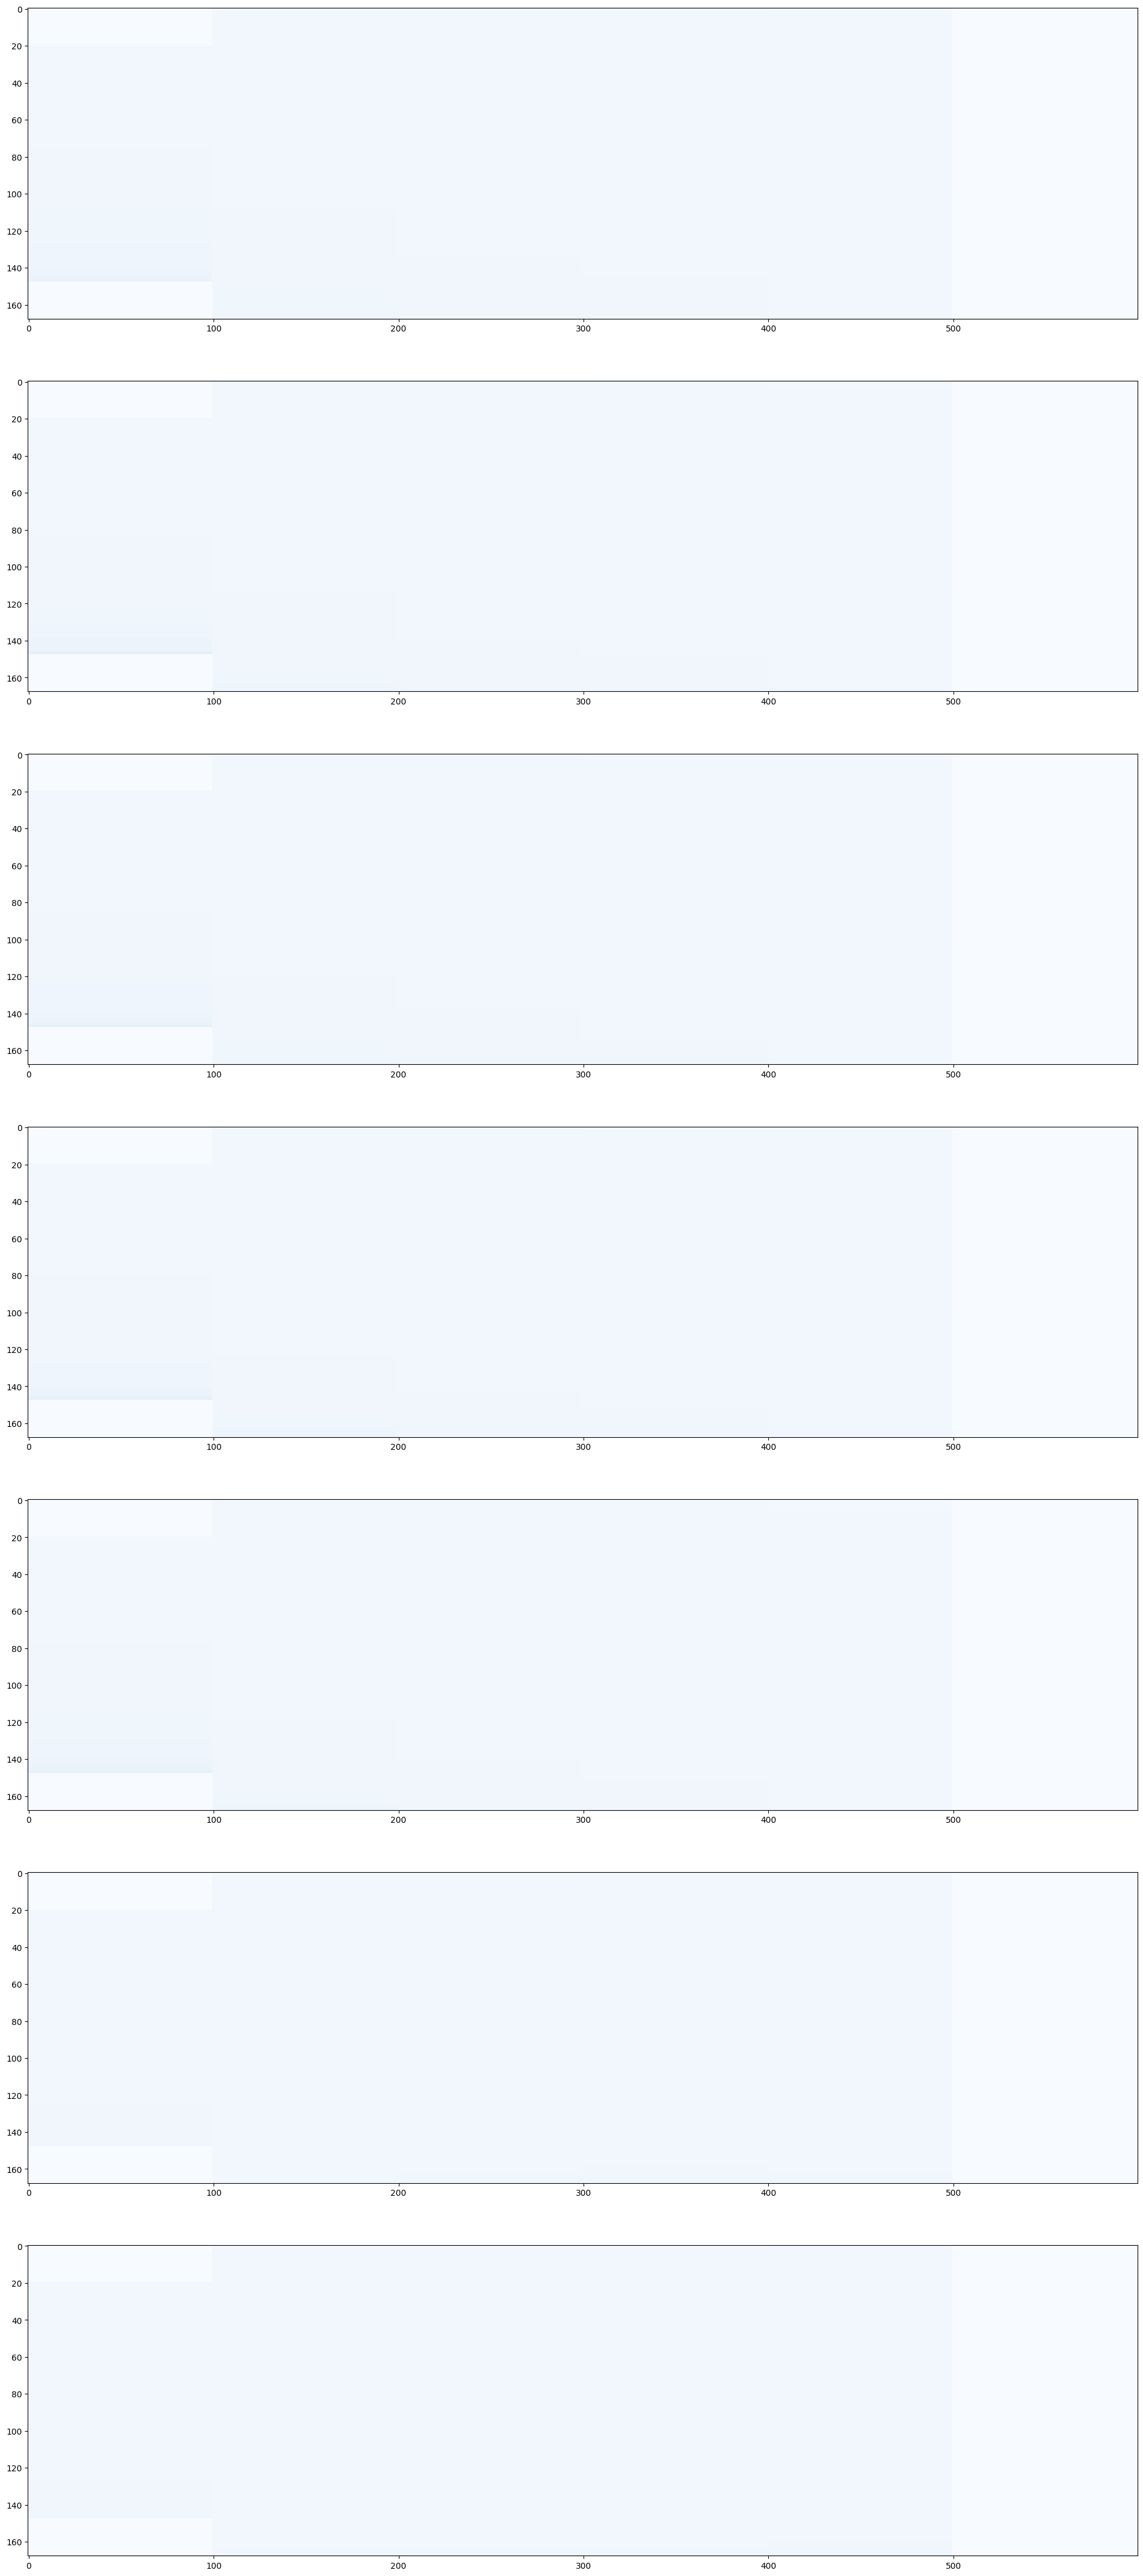

In [ ]:
d = "05"
number_of_rows = len(data[e][d]["Network"])
# number_of_rows = 3

fig, ax = plt.subplots(nrows=number_of_rows, ncols=1, figsize=(25, 55))

for j in range(number_of_rows):
  show_active_prime = []
  k = 0
  show_size = 0
  for i, active in enumerate(activations[d][j]):
    show_active = np.repeat(active[:, np.newaxis], 100, axis=1)
    show_active_prime.append(show_active)
    show_size = max(show_size, len(show_active))
    if i == 0:
      show_active_prime = []
      show_size = 0

  #print(show_size)
  final_show = []
  for show in show_active_prime:
    if show.shape[1] < show_size:
      gap = (show_size - show.shape[0])
      gap_p = int(gap / 2)
      #print(show_size, show.shape, gap)
      if gap == 0:
        t = show
      else:
        if gap % 2 == 1:
          t = np.concatenate([np.zeros((gap_p + 1, show.shape[1])), show, np.zeros((gap_p, show.shape[1]))], axis=0)
        else:
          t = np.concatenate([np.zeros((gap_p, show.shape[1])), show, np.zeros((gap_p, show.shape[1]))], axis=0)
      #print(t.shape)
      final_show.append(t)
  ax[j].imshow(np.concatenate(final_show, axis=1), cmap='Blues', interpolation='nearest', vmin=x_min, vmax=x_max)


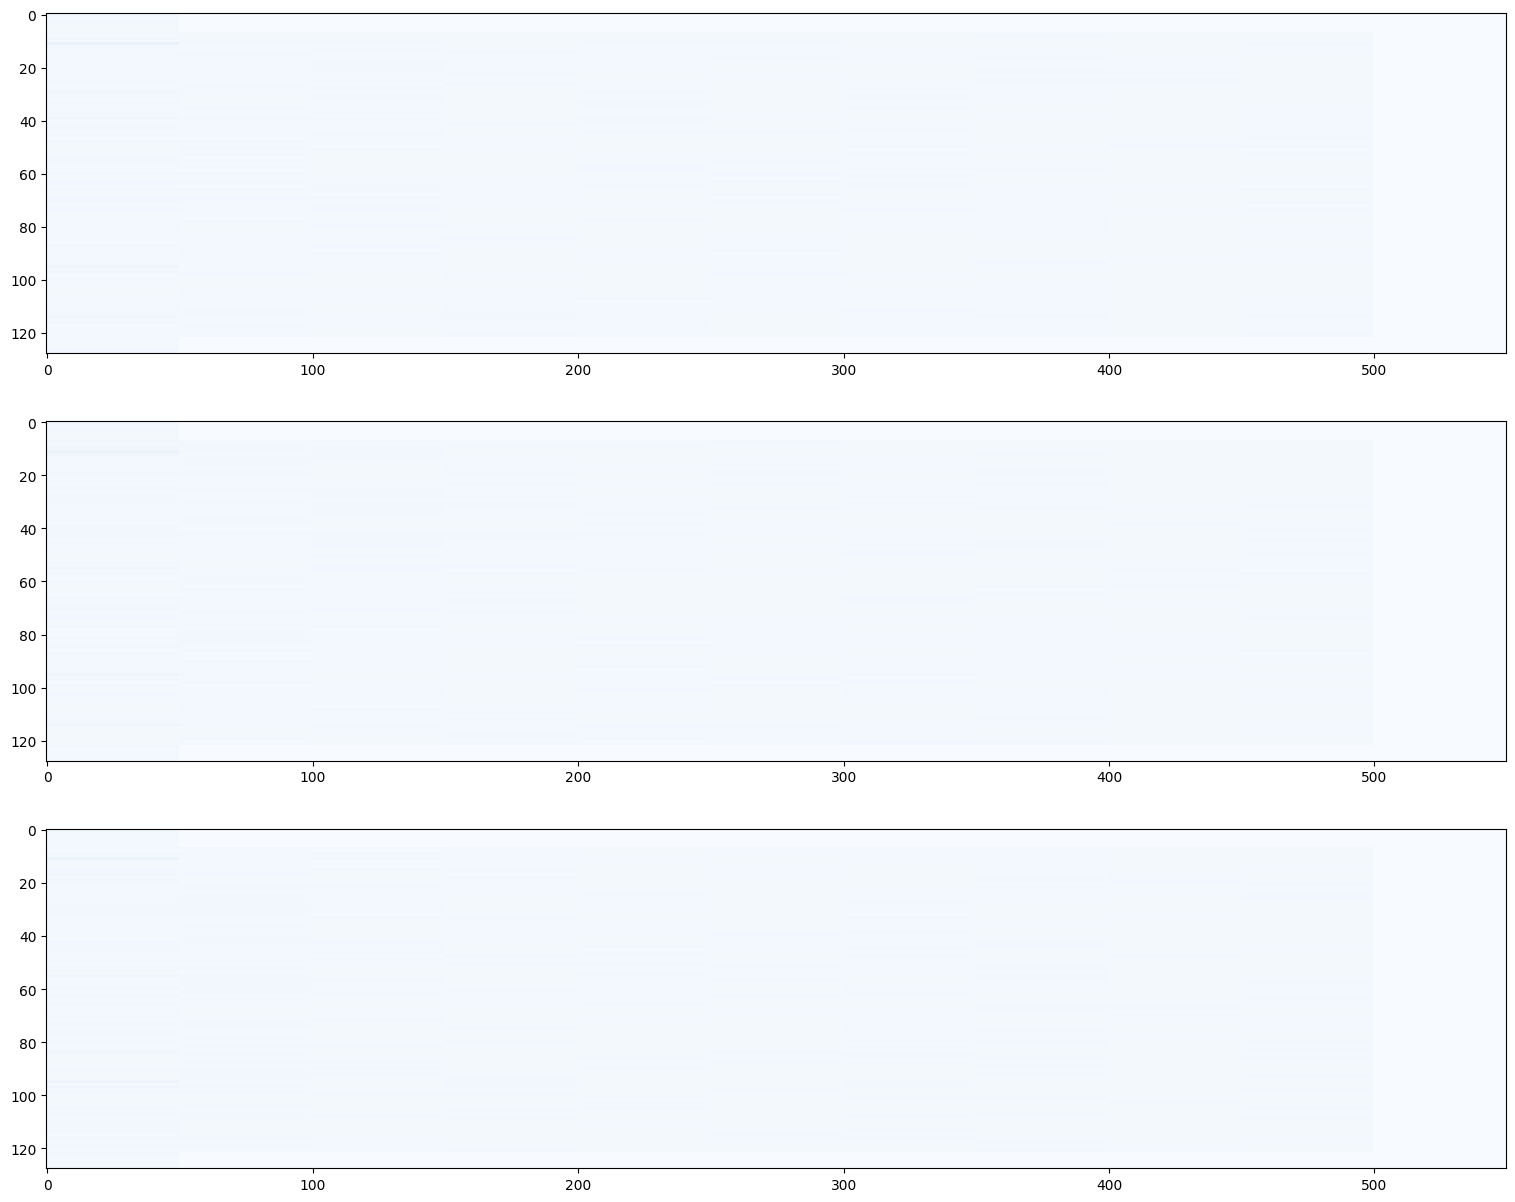

In [27]:
d = "10"
fig, ax = plt.subplots(nrows=3, ncols=1, figsize=(25, 15))
for j in range(3):
  show_active_prime = []
  k = 0
  show_size = 0
  for i, active in enumerate(activations[d][j]):
    show_active = np.repeat(active[:, np.newaxis], 50, axis=1)
    show_active_prime.append(show_active)
    show_size = max(show_size, len(show_active))
    if i == 0:
      show_active_prime = []
      show_size = 0
  #print(len(show_active_prime))
  #print(show_size)
  final_show = []
  for show in show_active_prime:
      gap = (show_size - show.shape[0])
      gap_p = int(gap / 2)
      #print(show_size, show.shape, gap)
      if gap == 0:
        t = show
      else:
        if gap % 2 == 1:
          t = np.concatenate([np.zeros((gap_p + 1, show.shape[1])), show, np.zeros((gap_p, show.shape[1]))], axis=0)
        else:
          t = np.concatenate([np.zeros((gap_p, show.shape[1])), show, np.zeros((gap_p, show.shape[1]))], axis=0)
      #print(t.shape)
      final_show.append(t)
  ax[j].imshow(np.concatenate(final_show, axis=1), cmap='Blues', interpolation='nearest', vmin=x_min, vmax=x_max)


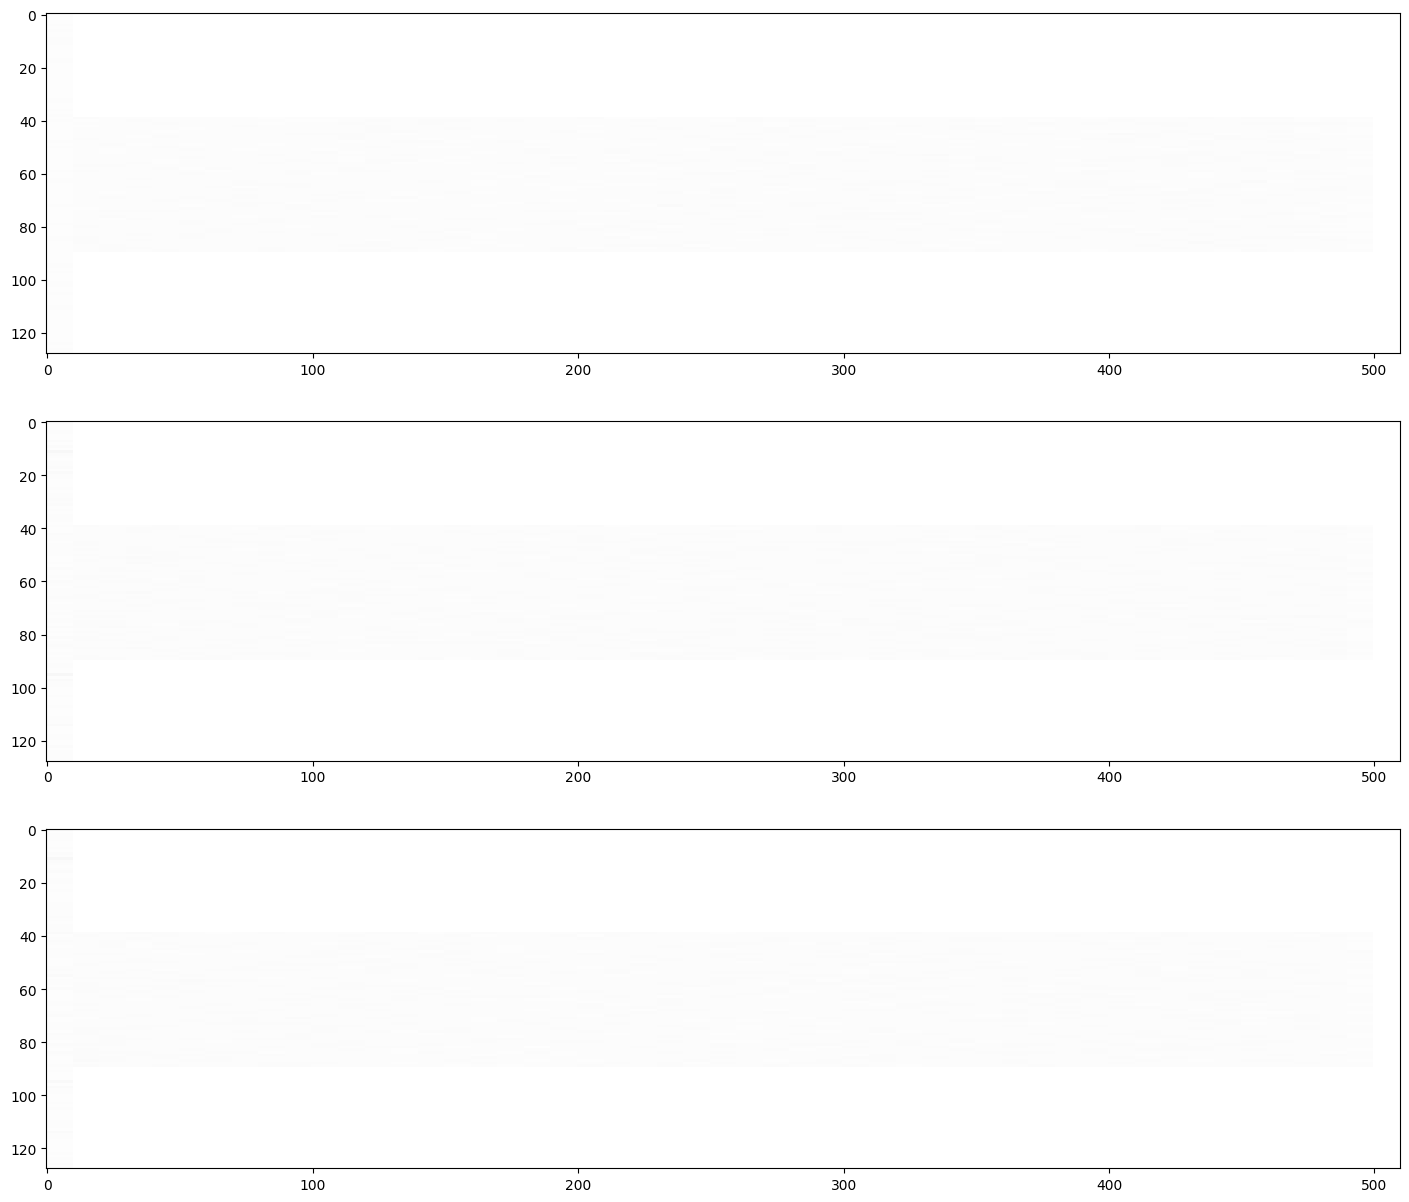

In [28]:
d = "50"
fig, ax = plt.subplots(nrows=3, ncols=1, figsize=(25, 15))
for j in range(3):
  show_active_prime = []
  k = 0
  show_size = 0
  for i, active in enumerate(activations[d][j]):
    show_active = np.repeat(active[:, np.newaxis], 10, axis=1)
    show_active_prime.append(show_active)
    show_size = max(show_size, len(show_active))
    if i == 0:
      show_active_prime = []
      show_size = 0

  #print(show_size)
  final_show = []
  for show in show_active_prime:
    if show.shape[1] < show_size:
      gap = (show_size - show.shape[0])
      gap_p = int(gap / 2)
      #print(show_size, show.shape, gap)
      if gap == 0:
        t = show
      else:
        if gap % 2 == 1:
          t = np.concatenate([np.zeros((gap_p + 1, show.shape[1])), show, np.zeros((gap_p, show.shape[1]))], axis=0)
        else:
          t = np.concatenate([np.zeros((gap_p, show.shape[1])), show, np.zeros((gap_p, show.shape[1]))], axis=0)
      #print(t.shape)
      final_show.append(t)
  ax[j].imshow(np.concatenate(final_show, axis=1), cmap='binary', interpolation='nearest', vmin=x_min, vmax=x_max)
